<a href="https://colab.research.google.com/github/boffandre-cyber/PEE---2025/blob/main/C%C3%B3pia_de_C%C3%B3pia_de_TRB1_PEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ainda em falta:

*   ajustar os comentários durante o código (padronizar mais), escrever uma breve
*   introdução explicando objetivos,
*   colocar todas as bibliotecas que estão sendo usadas na primeira secção de código e explica-las no texto,
*   ajustar texto dos gráficos e alguns gráficos com subíndices e explicar cada parte,
*   fazer a parte de texto do reservatório
* Melhorar os atuais textos

Introdução
---
___

Estação: DESPRAIADOS
código: 70100000
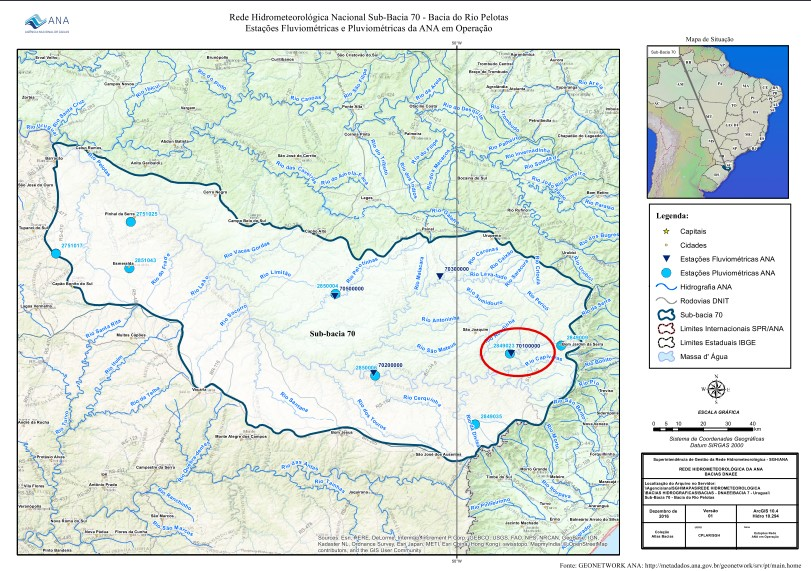

In [1]:
!git clone https://github.com/boffandre-cyber/PEE---2025.git

Cloning into 'PEE---2025'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 128 (delta 3), reused 0 (delta 0), pack-reused 120 (from 1)
Receiving objects: 100% (128/128), 10.61 MiB | 15.33 MiB/s, done.
Resolving deltas: 100% (75/75), done.


Importando Biblitecas e suas funções
---
---
Esta secção de códogo é dedicada e importar todas as bibliotecas que serão utilizadas ao longo do projeto, sendo elas:
*   Pandas:
*   Numpy:
*   Matplotlib:



In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

Lendo o arquivo de dados
---
---
Inicialmente foi buscado um arquivo fluvial no site da ANA (Agencia Nacional das Águas) o qual está no formato csv, portanto deve-se ajusta-lo para a leitura correta pela Biblioteca Pandas, afim de fazer uma análise de dados posterior em forma de dataframe


In [ ]:
# Esta função é necessária para lidar com o formato específico do arquivo,
# que contém metadados antes do cabeçalho.
import re # Import the re module

def read_complex_csv(file_path):
    """
    Lê um arquivo CSV com metadados e retorna um DataFrame.
    """
    with open(file_path, 'r', encoding='latin-1') as f:
        lines = f.readlines()

    # O cabeçalho está na linha 16 (índice 15).
    header_line = lines[15].strip()
    data_lines = lines[16:]

    # Obter os nomes das colunas, removendo aspas duplas.
    columns = [col.strip('"') for col in header_line.split(';')]

    # Processar as linhas de dados, removendo aspas e substituindo vírgulas por pontos.
    data = []
    for line in data_lines:
        if line.strip():  # Ignorar linhas vazias
            row = [re.sub(r'"', '', val).replace(',', '.') for val in line.split(';')]
            data.append(row)

    # Criar o DataFrame a partir dos dados processados.
    df = pd.DataFrame(data, columns=columns)

    # Remover colunas totalmente vazias ou sem nome
    df = df.dropna(axis=1, how='all')
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    return df

# Substitua '70100000_Vazoes_I.csv' pelo nome do arquivo.
file_path = 'PEE---2025/70100000_Vazoes_I.csv'
df = read_complex_csv(file_path)

Análise de Dados
---
___
Análise inicial de dados onde é ajustado os dados de vazões para estar em conformidade com o estipulado como premissa em edital da disciplina. Nela também são ajustadas as colunas que inicialmente são entendidas como variáveis de String, portanto são ajustadas datas na forma de DateTime e vazões como Float

In [ ]:
# -----------------------------------------------------------------------------
# Início da análise
# -----------------------------------------------------------------------------

# Converter a coluna 'Data' para o formato de data
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')

# Encontrar o ano mais recente nos dados
most_recent_year = df['Data'].dt.year.max()
print(f"Ano mais recente nos dados: {most_recent_year}")

# Definir o ano de corte para desconsiderar os dois últimos anos
year_cutoff = most_recent_year - 1
print(f"Os dados serão filtrados até o ano de: {year_cutoff - 1}")

# Filtrar o DataFrame para excluir os dois últimos anos
df_filtered = df[df['Data'].dt.year < year_cutoff].copy()

# Identificar as colunas de vazão, excluindo aquelas que contêm a palavra 'Status'
vazao_cols = [col for col in df_filtered.columns if 'Vazao' in col and 'Status' not in col]
print(f"\nColunas de vazão encontradas: {vazao_cols}")

# Desempilhar o DataFrame para obter uma única coluna com todos os valores de vazão
df_melted_filtered = df_filtered.melt(value_vars=vazao_cols, value_name='Vazao')

# Converter a coluna 'Vazao' para tipo numérico e remover valores ausentes
df_melted_filtered['Vazao'] = pd.to_numeric(df_melted_filtered['Vazao'], errors='coerce')
df_melted_filtered.dropna(subset=['Vazao'], inplace=True)

# Calcular a vazão média de longo termo
long_term_avg = df_melted_filtered['Vazao'].mean()

print(f"\nVazão média de longo termo (excluindo os dois últimos anos): {long_term_avg:.2f} m³/s")

# Definir o intervalo de referência e o valor alvo
lower_bound = 30
upper_bound = 60
target_avg = 45 # Ponto central do intervalo

# Verificar se a vazão média está fora do intervalo
if not (lower_bound <= long_term_avg <= upper_bound):
    print(f"\nA vazão média de longo termo está fora do intervalo [{lower_bound}, {upper_bound}] m³/s.")
    print("Aplicando fator de correção.")

    # Calcular o fator de correção
    correction_factor = target_avg / long_term_avg
    print(f"Fator de correção calculado: {correction_factor:.4f}")

    # Criar uma cópia do DataFrame original para aplicar a correção
    df_corrected = df.copy()

    # Aplicar o fator de correção a todas as colunas de vazão
    for col in vazao_cols:
        df_corrected[col] = pd.to_numeric(df_corrected[col], errors='coerce').mul(correction_factor)

    # Recalcular a média de longo termo com os dados corrigidos para verificação
    df_melted_corrected = df_corrected.melt(value_vars=vazao_cols, value_name='Vazao')
    df_melted_corrected['Vazao'] = pd.to_numeric(df_melted_corrected['Vazao'], errors='coerce')
    corrected_avg = df_melted_corrected['Vazao'].mean()
    print(f"Nova vazão média de longo termo após correção: {corrected_avg:.2f} m³/s")

    # Salvar o DataFrame corrigido em um novo arquivo CSV
    df_corrected.to_csv('70100000_Vazoes_I_Corrigido.csv', sep=';', index=False, decimal=',')
    print("\nUm novo arquivo CSV com os dados corrigidos foi gerado e está disponível como '70100000_Vazoes_I_Corrigido.csv'.")
else:
    print(f"\nA vazão média de longo termo já está dentro do intervalo [{lower_bound}, {upper_bound}] m³/s. Nenhuma correção é necessária.")


# Criando uma coluna de mediana:
#df_corrected['Mediana'] = df_corrected[vazao_cols].median(axis=1)

# Ajustantdo as colunas de media minima e maxima do df
df_corrected['Media'] = pd.to_numeric(df_corrected['Media'], errors='coerce')
df_corrected['Minima'] = pd.to_numeric(df_corrected['Minima'], errors='coerce')
df_corrected['Maxima'] = pd.to_numeric(df_corrected['Maxima'], errors='coerce')



for col in ['Media', 'Minima', 'Maxima']:
    df_corrected[col] = df_corrected[col] * correction_factor

# Criando uma coluna de mediana:
df_corrected['Mediana'] = df_corrected[vazao_cols].median(axis=1)

Ano mais recente nos dados: 2025
Os dados serão filtrados até o ano de: 2023

Colunas de vazão encontradas: ['Vazao01', 'Vazao02', 'Vazao03', 'Vazao04', 'Vazao05', 'Vazao06', 'Vazao07', 'Vazao08', 'Vazao09', 'Vazao10', 'Vazao11', 'Vazao12', 'Vazao13', 'Vazao14', 'Vazao15', 'Vazao16', 'Vazao17', 'Vazao18', 'Vazao19', 'Vazao20', 'Vazao21', 'Vazao22', 'Vazao23', 'Vazao24', 'Vazao25', 'Vazao26', 'Vazao27', 'Vazao28', 'Vazao29', 'Vazao30', 'Vazao31']

Vazão média de longo termo (excluindo os dois últimos anos): 16.96 m³/s

A vazão média de longo termo está fora do intervalo [30, 60] m³/s.
Aplicando fator de correção.
Fator de correção calculado: 2.6526
Nova vazão média de longo termo após correção: 45.31 m³/s

Um novo arquivo CSV com os dados corrigidos foi gerado e está disponível como '70100000_Vazoes_I_Corrigido.csv'.


Plotagem dos Gráficos
---
___
Aqui são plotados os gráficos de vazões para o histórico de 40 anos. São feitos os gráficos da vazão média mensal e curva de carga para todo o histórico.
Também nesta secção se encontra a criação de um ano sintético o qual foi utilizado para fazer os gráficos das médias mensais e de Rippl.

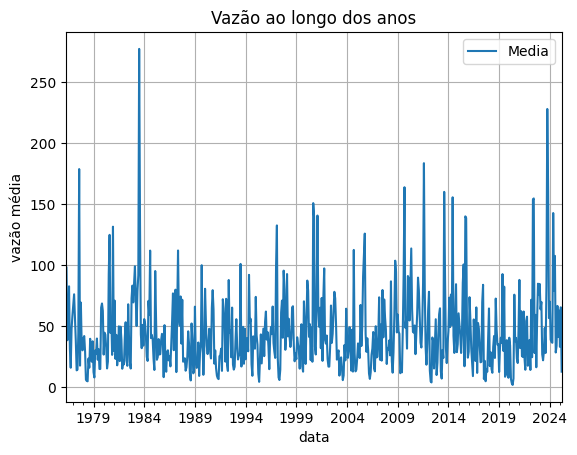

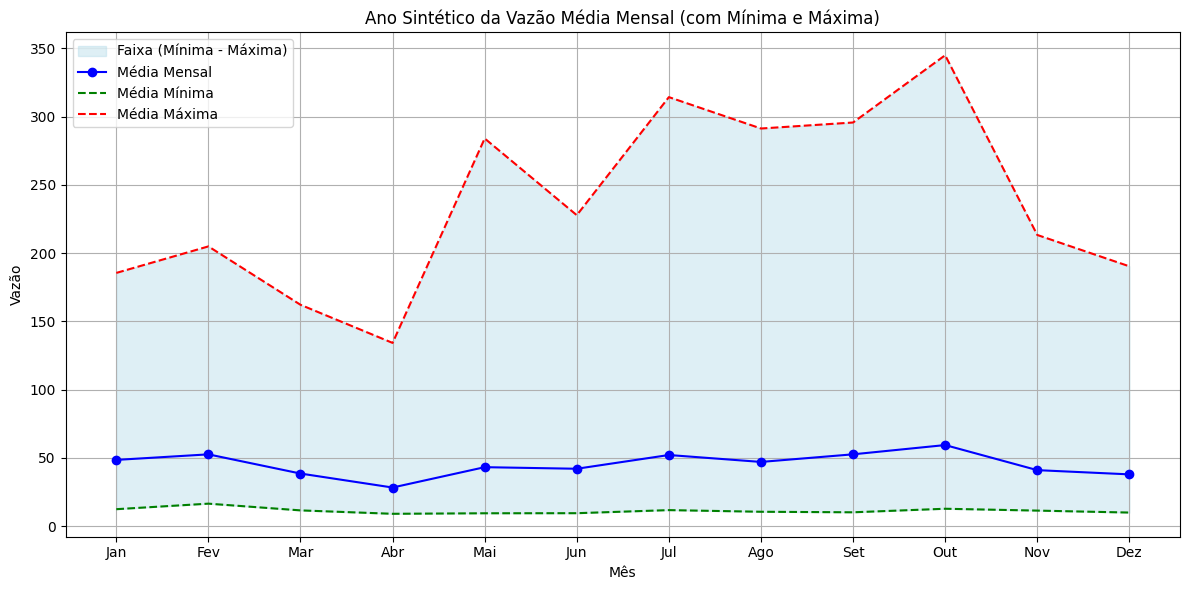

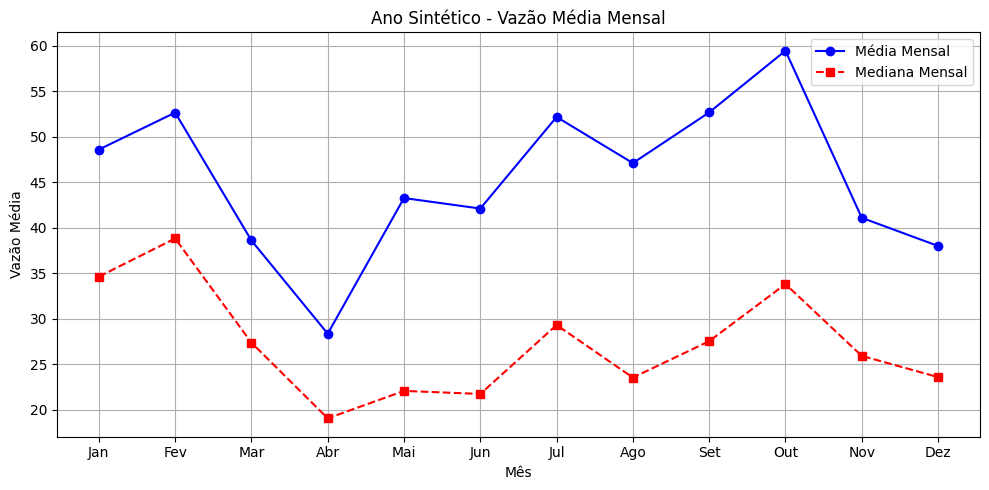

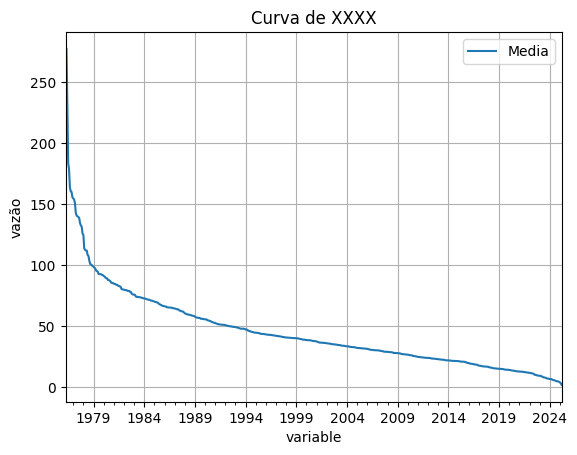

In [ ]:
#grafico de vazao da média mensal de todos os anos
df_corrected


#plotando todos os valores de média
df_corrected.plot(x='Data', y='Media', kind='line')
plt.title('Vazão ao longo dos anos')
plt.xlabel('data')
plt.ylabel('vazão média')
plt.grid(True)
plt.show()

#aqui plotar sazonalidades fazer media das medias, das minimas e das maximas dos meses.
df_anosintetico = df_corrected
# Extrai o mês da data
df_anosintetico['Mes'] = df_anosintetico['Data'].dt.month

# Agrupa por mês e calcula a média das médias, minimas, máximas e medianas:
media_mensal_sintetica = df_anosintetico.groupby('Mes')['Media'].mean().reset_index()
media_minima_sintetica = df_anosintetico.groupby('Mes')['Minima'].mean().reset_index()
media_maxima_sintetica = df_anosintetico.groupby('Mes')['Maxima'].mean().reset_index()
mediana_mensal_sintetica = df_anosintetico.groupby('Mes')['Mediana'].mean().reset_index()

# Dicionário para converter número do mês em nome
meses = {
    1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'
}
media_mensal_sintetica['MesNome'] = media_mensal_sintetica['Mes'].map(meses)
media_minima_sintetica['MesNome'] = media_mensal_sintetica['Mes'].map(meses)
media_maxima_sintetica['MesNome'] = media_mensal_sintetica['Mes'].map(meses)
mediana_mensal_sintetica['MesNome'] = mediana_mensal_sintetica['Mes'].map(meses)

# Ordena corretamente os meses
media_mensal_sintetica = media_mensal_sintetica.sort_values('Mes')


# Junta os três DataFrames em um só, usando 'Mes' como chave
df_plot = media_mensal_sintetica[['Mes', 'Media']].copy()
df_plot['Minima'] = media_minima_sintetica['Minima']
df_plot['Maxima'] = media_maxima_sintetica['Maxima']
df_plot['MesNome'] = df_plot['Mes'].map(meses)

# Ordena corretamente os meses
df_plot = df_plot.sort_values('Mes')

# Plotagem
plt.figure(figsize=(12, 6))

# Faixa entre mínima e máxima
plt.fill_between(
    df_plot['MesNome'],
    df_plot['Minima'],
    df_plot['Maxima'],
    color='lightblue',
    alpha=0.4,
    label='Faixa (Mínima - Máxima)'
)

# Linha da média
plt.plot(df_plot['MesNome'], df_plot['Media'], marker='o', color='blue', label='Média Mensal')

# Linha da mínima
plt.plot(df_plot['MesNome'], df_plot['Minima'], linestyle='--', color='green', label='Média Mínima')

# Linha da máxima
plt.plot(df_plot['MesNome'], df_plot['Maxima'], linestyle='--', color='red', label='Média Máxima')

# Ajustes do gráfico
plt.title('Ano Sintético da Vazão Média Mensal (com Mínima e Máxima)')
plt.xlabel('Mês')
plt.ylabel('Vazão')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Plotando a média
plt.figure(figsize=(10, 5))

# Linha da média mensal
plt.plot(media_mensal_sintetica['MesNome'], media_mensal_sintetica['Media'],
         marker='o', color='blue', label='Média Mensal')

# Linha da mediana mensal
plt.plot(
    mediana_mensal_sintetica['MesNome'], mediana_mensal_sintetica['Mediana'],
    marker='s', color='red', linestyle='--', label='Mediana Mensal'
)

# Ajustes do gráfico
plt.title('Ano Sintético - Vazão Média Mensal')
plt.xlabel('Mês')
plt.ylabel('Vazão Média')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plota o gráfico de XXX
df_ordenado = df_corrected
df_ordenado['Media'] = sorted(df_ordenado['Media'])
df_corrected.plot(x='Data', y='Media', kind='line')
plt.title('Curva de XXXX')
plt.xlabel('variable')
plt.ylabel('vazão')
plt.grid(True)
plt.show()


Grafico de Rippl
---
___

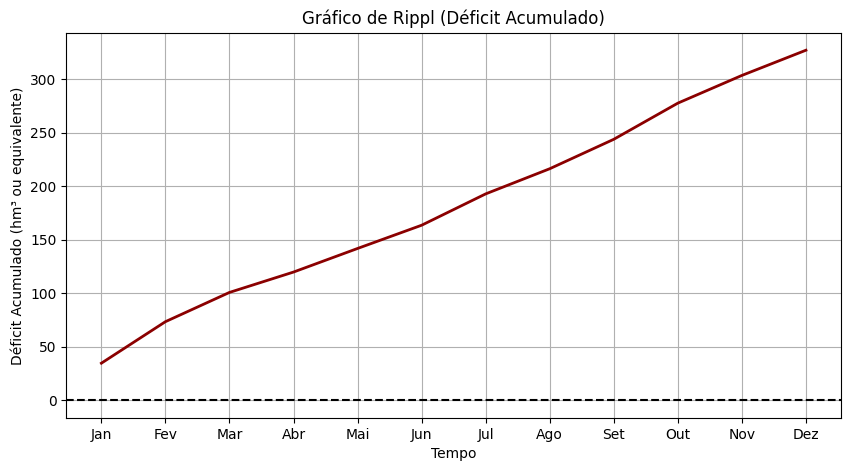

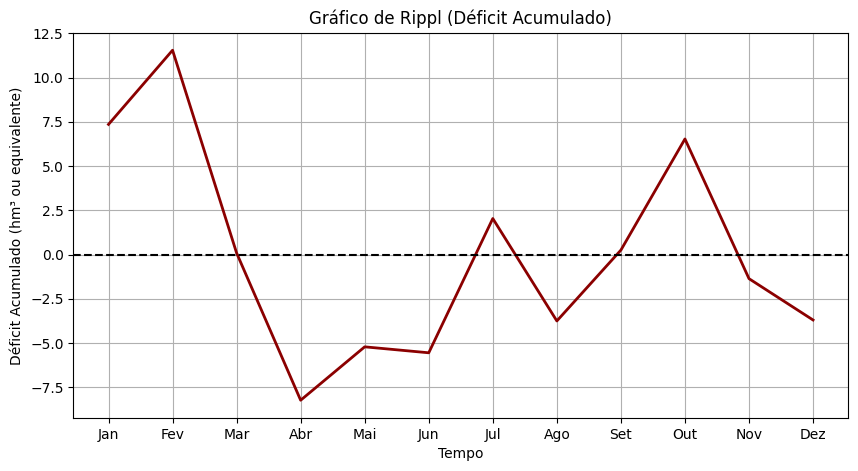

O valor máximo de Rippl é: 11.540878290212198
O valor mínimo de Rippl é: -8.227621315079404
O valor da regularização do reservatório é: 19.768499605291602


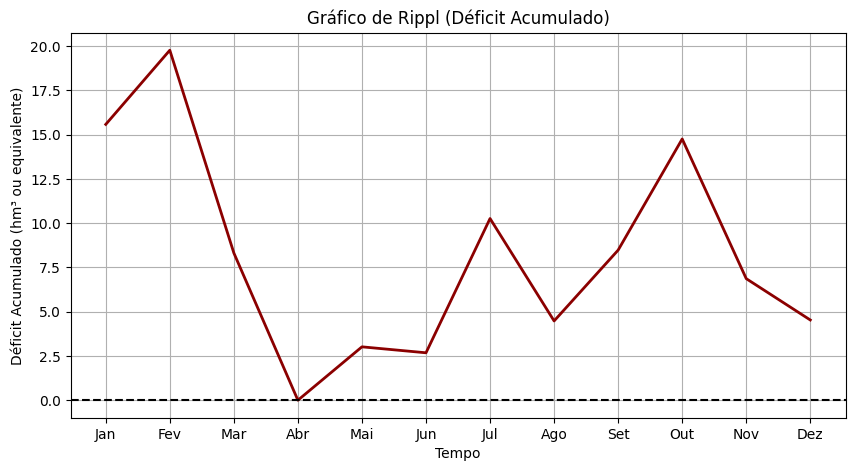

In [ ]:
# Definir a série de vazões a ser usada
serie_vazao = mediana_mensal_sintetica['Mediana']
vazão_acumulado = serie_vazao.cumsum()
media_medianas = mediana_mensal_sintetica['Mediana'].mean()

# Plotando a figura
plt.figure(figsize=(10, 5))
plt.plot(mediana_mensal_sintetica['MesNome'], vazão_acumulado, color='darkred', linewidth=2)
plt.axhline(0, color='black', linestyle='--')
plt.title('Gráfico de Rippl (Déficit Acumulado)')
plt.xlabel('Tempo')
plt.ylabel('Déficit Acumulado (hm³ ou equivalente)')
plt.grid(True)


# Rippl
Rippl_mensal = serie_vazao - media_medianas

# Plotar gráfico de Rippl
plt.figure(figsize=(10, 5))
plt.plot(media_mensal_sintetica['MesNome'], Rippl_mensal, color='darkred', linewidth=2)
plt.axhline(0, color='black', linestyle='--')
plt.title('Gráfico de Rippl (Déficit Acumulado)')
plt.xlabel('Tempo')
plt.ylabel('Déficit Acumulado (hm³ ou equivalente)')
plt.grid(True)
plt.show()

# Ajustando o gráfico de Rippl para tamanho do reservatório
Rippl_maximo = Rippl_mensal.max()
Rippl_minimo = Rippl_mensal.min()
reservatorio_regularizacao = Rippl_maximo - Rippl_minimo
print(f"O valor máximo de Rippl é: {Rippl_maximo}")
print(f"O valor mínimo de Rippl é: {Rippl_minimo}")
print(f"O valor da regularização do reservatório é: {reservatorio_regularizacao}")


Rippl_corrigido = Rippl_mensal - Rippl_minimo

plt.figure(figsize=(10, 5))
plt.plot(media_mensal_sintetica['MesNome'], Rippl_corrigido, color='darkred', linewidth=2)
plt.axhline(0, color='black', linestyle='--')
plt.title('Gráfico de Rippl (Déficit Acumulado)')
plt.xlabel('Tempo')
plt.ylabel('Déficit Acumulado (hm³ ou equivalente)')
plt.grid(True)

## Determinação Reservatório
* * *

A rotina a seguir implementa um balanço mensal do volume de um reservatório, conforme a seguinte expressão:

  \begin{align}
  [
	V_f = V_i + \Delta V_Q,
	]
  \end{align}
em que:

\begin{align}
 \Delta V_Q = \left(Q_{in} - Q_{out}\right) \cdot {N dias} \cdot 24 \cdot 60 \cdot 60
 \end{align}


Assim, as vazões médias mensais (em m³/s) são integradas no tempo, resultando em variações de volume em m³.

Ao final, o código calcula o Volume Útil do Reservatório $VRu$ como:

\begin{align}
  VR_u = \max(V_f)
  \end{align}

Os dados de entrada são: Mês, Qsintética (m³/s) e Qsaida (m³/s), obtidos pela leitura do arquivo Reservatorio_1.xlsx.

O fluxograma básico da rotina:

1) Volume incial $V_i = 0.0$ (janeiro inicia zerado).
2) Para cada mês $i$, lê $Qin$ e $Qout$, e a partir do número de dias do mês, calcula $Qliq = (Qin -Qout)$.
3) Faz a integração no mês $ΔVQ = Qliq*24*60*60$.
4) Atualiza o volume: $V_f = V_i + dV_Q$.
5) Guarda os valores em lista e propaga o estado: $V_i = V_f$ (o próximo mês começa no volume final deste mês).
6) No final, determina o volume útil do reservatório: $VR_u = max(V_f)$.

In [3]:
import os
import numpy as np
import pandas as pd

def _to_float(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)): return float(x)
    return float(str(x).replace(',', '.'))

def _col(df, nome):
    alvo = nome.strip().lower()
    for k in df.columns:
        if k.strip().lower() == alvo:
            return k
    raise KeyError(f"Coluna obrigatória não encontrada: '{nome}'. Presentes: {list(df.columns)}")

# ---- entrada ----
# Corrected path to look within the cloned repository directory
ARQ = r"PEE---2025/Reservatorio_1.xlsx"
if not os.path.exists(ARQ):
    # Check if the file is in the current directory as a fallback
    if os.path.exists("Reservatorio_1.xlsx"):
        ARQ = "Reservatorio_1.xlsx"
    else:
        raise FileNotFoundError(f"Arquivo não encontrado: {ARQ}. Certifique-se de que 'Reservatorio_1.xlsx' está na pasta 'PEE---2025' ou no diretório atual.")


df = pd.read_excel(ARQ)

# Normaliza números
for nome in ["Qsintética", "Qsaida"]:
    df[_col(df, nome)] = df[_col(df, nome)].map(_to_float)

# Dias (se não houver, usa calendário padrão)
dias_padrao = [31,28,31,30,31,30,31,31,30,31,30,31]
if any(cn.strip().lower() == "dias" for cn in df.columns):
    df["Dias"] = df[_col(df, "Dias")].map(_to_float)
else:
    df["Dias"] = pd.Series(dias_padrao[:len(df)])

# ---- balanço simples ----
CASAS_Q = 3  # arredondamento de Qliq (m³/s)
n = len(df)

Vi_list, Vf_list, Qliq_list, dV_Q_list = [], [], [], []

V_i = 0.0  # janeiro começa zerado
for i in range(n):
    Qin  = _to_float(df[_col(df, "Qsintética")].iloc[i])  # m³/s
    Qout = _to_float(df[_col(df, "Qsaida")].iloc[i])      # m³/s
    dias = float(df["Dias"].iloc[i])

    Qliq = round(Qin - Qout, CASAS_Q)               # m³/s
    dV_Q = Qliq * dias * 24 * 60 * 60               # m³
    V_f  = V_i + dV_Q                                # soma

    Vi_list.append(V_i);  Vf_list.append(V_f)
    Qliq_list.append(Qliq); dV_Q_list.append(dV_Q)

    V_i = V_f  # próximo mês começa em Vf

# ---- tabela final (somente balanço) ----
out = pd.DataFrame({
    "Mês": df[_col(df,"Mês")] if "Mês" in df.columns else np.arange(1, n+1),
    "Dias": df["Dias"].astype(int),
    "Q_in (m3/s)": df[_col(df,"Qsintética")].round(3),
    "Q_out (m3/s)": df[_col(df,"Qsaida")].round(3),
    "Qliq (m3/s)": np.array(Qliq_list).round(CASAS_Q),
    "ΔV_Q (m3)":   np.array(dV_Q_list).round(2),
    "Vi (m3)":     np.array(Vi_list).round(2),
    "Vf (m3)":     np.array(Vf_list).round(2),
})

# ---- VR: Volume do Reservatório = max(Vf) ----
VRu = float(out["Vf (m3)"].max() )
print(f"VRu (Volume Útil do Reservatório) = {VRu:,.2E} m³")

# ---- salvar Excel ----
#out_path = r"C:\Users\boffa\Downloads\TMP\BalancoReservatorio_.xlsx"
#out.to_excel(out_path, index=False)

#out  # exibe no notebook
#print(f"\nArquivo Excel salvo em: {out_path}")

VRu (Volume Útil do Reservatório) = 4.79E+07 m³


A rotina a seguir faz o dimensionamento do reservatório trapezoidal a partir do volume útil do reservatório $VR_u$.

##### Entradas
- $VR_u$ é o valor determinado na célula anterior (variável de ambiente).
- **Parâmetro fixo: $a=30$

Reservatório trapezoidal com:
- altura \(a\) (fixa),
- parâmetro geométrico \(c\),
- largura da base menor \(w_0\),
- largura da base maior \(w_1\),
- profundidade \(D\) (constante ao longo da altura).

As relações empregadas são:
- Volume máximo:
  $$
  V_{\max} \;=\; 750\,c^{2}\,a
  $$
- Cálculo de \(c\) (a partir do \(V_{\max}\) informado ou padrão):
  $$
  c \;=\; \sqrt{\frac{V_{\max}}{750\,a}}
  $$
- Dimensões derivadas:
  $$
  w_0 \;=\; 20\,c,\qquad
  w_1 \;=\; 40\,c,\qquad
  D \;=\; 25\,c
  $$

##### Fluxo da rotina
1. Leitura de $VR_u$.    
2. Cálculo de \(c\) pela fórmula acima.  
3. Cálculo de dimensões \(w_0\), \(w_1\), \(D\).  
4. Cálculo de verificação do volume:  
   $$
   V_{\max}^{(\mathrm{calc})} \;=\; 750\,c^{2}\,a
   $$
5. Impressão dos resultados na tela:
   - \(a\) (m)  
   - \(c\) (m) — informado como “fixo a partir de agora” para uso posterior  
   - \(w_0=20c\), \(w_1=40c\), \(D=25c\) (m)  
   - $VR_u$ informado (m³) e \($V_{\max}^{(\mathrm{calc})}$\) reconstituído (m³)



In [4]:
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

# ----------------- parâmetros -----------------
a = 30.0  # altura máxima (m)

# Entrada => usa Volume definido na célula anterior
vmax = VRu

# ----------------- cálculo de c e dimensões -----------------
# Vmax = 750 * c^2 * a  =>  c = sqrt(Vmax / (750*a))
c = math.sqrt(vmax / (750.0 * a))
w0 = 20.0 * c          # base menor (largura no z=0)
w1 = 40.0 * c          # base maior (largura no z=a)
D  = 25.0 * c          # profundidade (constante)
vmax_calc = 750.0 * (c**2) * a
# ----------------- impressão no console -----------------
print("\n=== RESULTADOS ===")
print(f"a = {a:.2f} m")
print(f"c = {c:.2E} m (fixo a partir de agora)")
print(f"Base menor (20c) = {w0:.2E} m, Base maior (40c) = {w1:.2E} m, Profundidade (25c) = {D:.2E} m")
print(f"Volume máximo informado = {vmax:,.2E} m³")
print(f"Volume máximo calculado (a partir de c) = {vmax_calc:,.2E} m³")



=== RESULTADOS ===
a = 30.00 m
c = 4.61E+01 m (fixo a partir de agora)
Base menor (20c) = 9.23E+02 m, Base maior (40c) = 1.85E+03 m, Profundidade (25c) = 1.15E+03 m
Volume máximo informado = 4.79E+07 m³
Volume máximo calculado (a partir de c) = 4.79E+07 m³


Avaliação da conformidade do reservatório com o Edital.
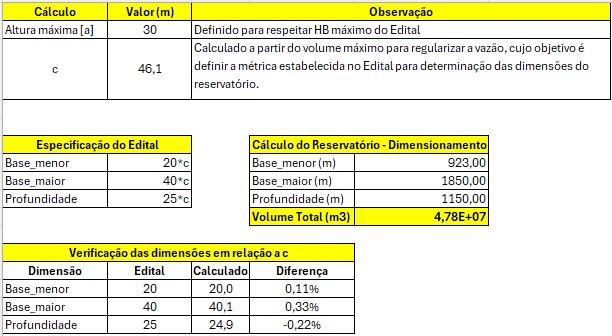

A rotina seguinte estabelece que o reservatório já esteja definido. A partir da leitura  do arquivo Reservatorio_1.xlsx, obtém os dados das colunas: Mês, Qsintética(Q_in), Qsaida (Q_out) e, dependendo da escolha ao rodar a célula, se no modo avaliação ou não dos dados de Evaporação e Precipitação ($E/P$), obtém também dos dados de Evaporação e Precipitação.
#####Balanço mês a mês

- Vazão líquida:

  $$ Q_{\text{liq}} = Q_{\text{in}} - Q_{\text{out}} $$

- Variação por vazões:

  $$ \Delta V_Q = Q_{\text{liq}} \cdot \text{Dias} \cdot 86400 $$

- Sem P/E:

  $$ V_f = V_i + \Delta V_Q $$

- Com P/E (iteração com área média):

O volume é uma função não linear com a altura da lâmina de água, e são calculadas de forma iterativa pelas seguintes relações, a partir das dimensões a, b e c:

  $$ V(b)=500c^2b+a250c^2​b^2\$$\
  \$$A(b) = dV/db ​= 500c^2+a500c^2​b=500c^2(1+a/b​)\$$



  $$ V_f = V_i + \Delta V_Q + (P - E)\cdot A_{\text{média}} $$
##### Ao final da rotina são geradas as seguintes saídas:

- Tabela final com:
  - Mês, Dias
  - $Q_{in}$, $Q_{out}$, $Q_{liq}$
  - $\Delta V_Q$, $\Delta V_{(P-E)}$
  - $V_i$, $V_f$
  - $b_i$, $b_f$
  - $A_i$, $A_f$
  - \% do volume em relação a $V_{\max}$
- Exporta para Excel:
  - **Sem P/E** → `BalancoReservatorio_semPE_.xlsx`
  - **Com P/E** → `BalancoReservatorio_comPE_.xlsx`
- Exibe a tabela ao final.

In [9]:
import os, math
import numpy as np
import pandas as pd

# ---------- checagens ----------
try:
    a, c
except NameError:
    raise RuntimeError("As variáveis 'a' e 'c' não existem. Rode as células anteriores primeiro.")

# ---------- pergunta ao usuário ----------
# Digite: S para rodar COM precipitação/evaporação; N para rodar SEM (apenas vazões)
try:
    escolha = input("Deseja considerar precipitação/evaporação? [S/N]: ").strip().upper()
except Exception:
    escolha = "N"
use_PE = (escolha == "S")

# ---------- caminhos ----------
# Corrected path to look within the cloned repository directory
ARQ_IN  = r"PEE---2025/Reservatorio_1.xlsx"
OUT_DIR = r"PEE---2025" # Use a directory within the cloned repo for output
OUT_SEM = os.path.join(OUT_DIR, "BalancoReservatorio_semPE_.xlsx")
OUT_COM = os.path.join(OUT_DIR, "BalancoReservatorio_comPE_.xlsx")

# Fallback to current directory if the PEE---2025 directory is not found
if not os.path.exists(ARQ_IN):
    cand = [p for p in os.listdir(".") if p.lower() == "reservatorio_1.xlsx"]
    if cand:
        ARQ_IN = cand[0]
        OUT_DIR = os.getcwd()
        OUT_SEM = os.path.join(OUT_DIR, "BalancoReservatorio_semPE_.xlsx")
        OUT_COM = os.path.join(OUT_DIR, "BalancoReservatorio_comPE_.xlsx")
    else:
        raise FileNotFoundError(
            f"Não encontrei 'Reservatorio_1.xlsx'. "
            f"Certifique-se de que '{os.path.basename(ARQ_IN)}' está na pasta '{os.path.dirname(ARQ_IN)}' ou no diretório atual."
        )


# ---------- leitura ----------
df = pd.read_excel(ARQ_IN)

def _to_float(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)): return float(x)
    # vírgula decimal -> ponto
    return float(str(x).replace(',', '.'))

def _col(df_, nome):
    alvo = nome.strip().lower()
    for k in df_.columns:
        if k.strip().lower() == alvo:
            return k
    raise KeyError(f"Coluna obrigatória não encontrada: '{nome}'. Presentes: {list(df.columns)}")

# colunas obrigatórias
col_mes = _col(df, "Mês") if any(c.strip().lower()=="mês" for c in df.columns) else None
col_qi  = _col(df, "Qsintética")
col_qo  = _col(df, "Qsaida")

# Evap e Prec são usados apenas se use_PE = True
col_ev, col_pr = None, None
if use_PE:
    col_ev = _col(df, "Evaporação")
    col_pr = _col(df, "Precipitação")

# Dias (se não houver, usa calendário padrão)
dias_padrao = [31,28,31,30,31,30,31,31,30,31,30,31]
if any(cn.strip().lower()=="dias" for cn in df.columns):
    col_dias = _col(df, "Dias")
    df["Dias"] = df[col_dias].map(_to_float)
else:
    df["Dias"] = pd.Series(dias_padrao[:len(df)])

# normaliza numéricos de vazões (m³/s)
df[col_qi] = df[col_qi].map(_to_float)
df[col_qo] = df[col_qo].map(_to_float)
if use_PE:
    df[col_ev] = df[col_ev].map(_to_float)  # mm
    df[col_pr] = df[col_pr].map(_to_float)  # mm

# ---------- geometria do reservatório ----------
Vmax = 750.0*(c**2)*a

def V_de_b(b):
    return 500.0*(c**2)*b + (250.0*(c**2)/a)*(b**2)

def b_de_V(V):
    # Inverso físico, clamp em [0, Vmax] para obter nível válido
    Vc = max(0.0, min(float(V), Vmax))
    A = 250.0*(c**2)/a
    B = 500.0*(c**2)
    C = -Vc
    disc = B*B - 4*A*C
    if disc < 0:  # numérico
        return 0.0
    r1 = (-B + math.sqrt(disc))/(2*A)
    r2 = (-B - math.sqrt(disc))/(2*A)
    return max(0.0, min(max(r1, r2, 0.0), a))

def A_lamina(b):
    return 500.0*(c**2)*(1.0 + b/a)

# ---------- balanço ----------
CASAS_Q = 3                 # arredondamento da vazão líquida para bater com sua planilha
seg_dia = 86400.0
n = len(df)

M_str = df[col_mes].astype(str).tolist() if col_mes else [f"Mês {i+1}" for i in range(n)]
Qi   = df[col_qi].astype(float).values
Qo   = df[col_qo].astype(float).values
Dias = df["Dias"].astype(float).values

Vi_list, Vf_list = [], []
bi_list, bf_list = [], []
Ai_list, Af_list = [], []
Qliq_list, dV_Q_list = [], []
dV_PE_list = []  # 0 no modo sem P/E
perc_list = []

V_i = 0.0  # janeiro começa zerado

for i in range(n):
    # Vazão líquida (m³/s), arredondada
    Qliq = round(Qi[i] - Qo[i], CASAS_Q)
    # Variação por vazões
    dV_Q = Qliq * Dias[i] * 24 * 60 * 60  # m³

    if not use_PE:
        # ------------- MODO SEM P/E (idêntico à lógica original solicitada) -------------
        V_f = V_i + dV_Q
        b_i = b_de_V(V_i); A_i = A_lamina(b_i)
        b_f = b_de_V(V_f); A_f = A_lamina(b_f)
        dV_PE = 0.0
    else:
        # ------------- MODO COM P/E -------------
        # mm -> m
        E_m = 0.001 * max(_to_float(df[col_ev].iloc[i]), 0.0)  # evaporação (m)
        P_m = 0.001 * max(_to_float(df[col_pr].iloc[i]), 0.0)  # precipitação (m)

        # área no início
        b_i = b_de_V(V_i); A_i = A_lamina(b_i)

        # iteração de ponto fixo usando A_média = (A_i + A_f)/2
        V_guess = V_i + dV_Q + (P_m - E_m) * A_i
        for _ in range(30):
            b_f = b_de_V(V_guess)
            A_f = A_lamina(b_f)
            A_med = 0.5*(A_i + A_f)
            V_new = V_i + dV_Q + (P_m - E_m) * A_med
            if abs(V_new - V_guess) <= 1e-9 * max(1.0, abs(V_new)):
                V_guess = V_new
                break
            V_guess = V_new

        V_f = V_guess
        # valores finais
        b_f = b_de_V(V_f); A_f = A_lamina(b_f)
        dV_PE = (P_m - E_m) * 0.5*(A_i + A_f)

    # guarda
    Vi_list.append(V_i); Vf_list.append(V_f)
    bi_list.append(b_i); bf_list.append(b_f)
    Ai_list.append(A_i); Af_list.append(A_f)
    Qliq_list.append(Qliq); dV_Q_list.append(dV_Q)
    dV_PE_list.append(dV_PE)

    # % do volume em relação ao volume total (usando volume físico do nível b_f)
    V_phys_f = V_de_b(bf_list[-1])
    perc_list.append(100.0 * V_phys_f / Vmax if Vmax > 0 else np.nan)

    # Próximo mês
    V_i = V_f

# ---------- tabela de saída ----------
out = pd.DataFrame({
    "Mês": M_str,
    "Dias": np.array(Dias).astype(int),
    "Q_in (m3/s)": np.round(Qi, 3),
    "Q_out (m3/s)": np.round(Qo, 3),
    "Qliq (m3/s)": np.round(Qliq_list, CASAS_Q),
    "ΔV_Q (m3)":   np.round(dV_Q_list, 2),
    "ΔV_(P-E) (m3)": np.round(dV_PE_list, 2),
    "Vi (m3)":     np.round(Vi_list, 2),
    "Vf (m3)":     np.round(Vf_list, 2),
    "b_i (m)":     np.round(bi_list, 3),
    "b_f (m)":     np.round(bf_list, 3),
    "A_i (m2)":    np.round(Ai_list, 2),
    "A_f (m2)":    np.round(Af_list, 2),
    "% Volume [%]": np.round(perc_list, 2),
})

# ---------- salvar Excel ----------
destino = OUT_COM if use_PE else OUT_SEM
try:
    os.makedirs(os.path.dirname(destino), exist_ok=True)
    out.to_excel(destino, index=False)
    print(("Rodando COM P/E → " if use_PE else "Rodando SEM P/E → ") +
          f"arquivo salvo em: {destino}")
except Exception:
    # fallback: salvar no diretório atual
    destino = os.path.join(os.getcwd(), os.path.basename(destino))
    out.to_excel(destino, index=False)
    print(("Rodando COM P/E → " if use_PE else "Rodando SEM P/E → ") +
          f"salvei no diretório atual: {destino}")

# ---------- exibir tabela ----------
out

Deseja considerar precipitação/evaporação? [S/N]: n
Rodando SEM P/E → arquivo salvo em: PEE---2025/BalancoReservatorio_semPE_.xlsx


,Mês,Dias,Q_in (m3/s),Q_out (m3/s),Qliq (m3/s),ΔV_Q (m3),ΔV_(P-E) (m3),Vi (m3),Vf (m3),b_i (m),b_f (m),A_i (m2),A_f (m2),% Volume [%]
0,Jan,31,34.6,27.267,7.333,19640707.2,0.0,0.0,19640707.2,0.000,14.801,1064390.40,1589534.19,41.01
1,Fev,28,38.8,27.267,11.533,27900633.6,0.0,19640707.2,47541340.8,14.801,29.832,1589534.19,2122835.38,99.26
2,Mar,31,27.4,27.267,0.133,356227.2,0.0,47541340.8,47897568.0,29.832,30.000,2122835.38,2128780.80,100.00
3,Abr,30,19.0,27.267,-8.267,-21428064.0,0.0,47897568.0,26469504.0,30.000,18.909,2128780.80,1735276.92,55.26
4,Mai,31,22.1,27.267,-5.167,-13839292.8,0.0,26469504.0,12630211.2,18.909,10.149,1735276.92,1424485.39,26.37
5,Jun,30,21.7,27.267,-5.567,-14429664.0,0.0,12630211.2,-1799452.8,10.149,0.000,1424485.39,1064390.40,0.00
6,Jul,31,29.3,27.267,2.033,5445187.2,0.0,-1799452.8,3645734.4,0.000,3.249,1064390.40,1179671.95,7.61
7,Ago,31,23.5,27.267,-3.767,-10089532.8,0.0,3645734.4,-6443798.4,3.249,0.000,1179671.95,1064390.40,0.00
8,Set,30,27.5,27.267,0.233,603936.0,0.0,-6443798.4,-5839862.4,0.000,0.000,1064390.40,1064390.40,0.00
9,Out,31,33.8,27.267,6.533,17497987.2,0.0,-5839862.4,11658124.8,0.000,9.461,1064390.40,1400064.28,24.34


Verificação da implementação do cálculo da área da lâmina de água em função de sua altura dentro do reservatório.
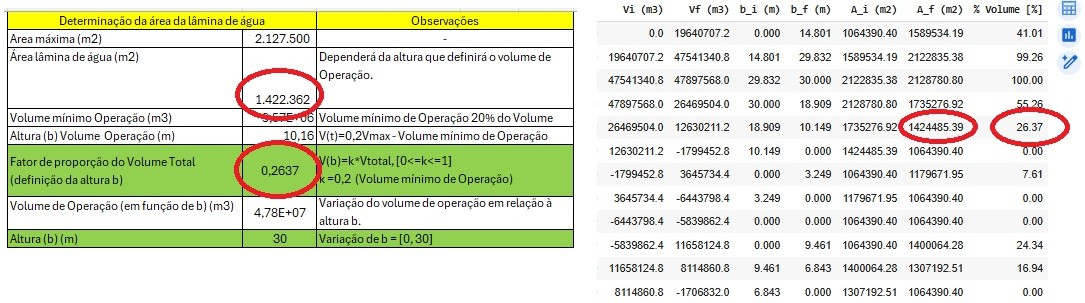

A rotina seguinte faz a animação e detecção de vertimento do reservatório, (COM/SEM $P–E$).
Inicialmente lê a planilha de balanço mensal (com ou sem precipitação/evaporação), reconstrói a lâmina d’água no reservatório 3D mês a mês, faz a animação da evolução do volume de água no reservatório e detecta o vertimento quando $V_f > V_{\max}$.
######Após a leituras das informações de entrada e das dimenões do reservatório, executa os seguintes cálculos:
- Recalcula volume e área da lâmina de água, conforme rotina anterior.

##### Detecção de vertimento
- Cálculo mensal:
  $$ \text{extravaso} = \max\!\big(V_f - V_{\max},\, 0\big) $$
- indica os meses com vertimento e soma o total extravasado.

##### Trajetória e animação
- Interpola linearmente de $Vi → Vf$.
- Para cada frame:
  1. Converte volume do frame em nível $b$ via $b_{\text{de }V}(V)$.
  2. Atualiza o polígono 3D da água.
  3. Atualiza o título com: mês, $b$, $V(\text{desenho})$, $A(b)$, $V(\text{planilha})$ e destaque de vertimento quando houver.

##### Como saída da rotina são produzidos:
- A apresentação do GIF do reservatório na tela.
- As mensagens finais:
  - Lista meses com extravaso (valor e comparação $V_f$ vs $V_{\max}$).
  - Total extravasado no período; ou “Sem vertimento”.

Considerar precipitação/evaporação? [S/N]: n
GIF salvo em: PEE---2025/Reservatorio_VolumeAnim_semPE.gif


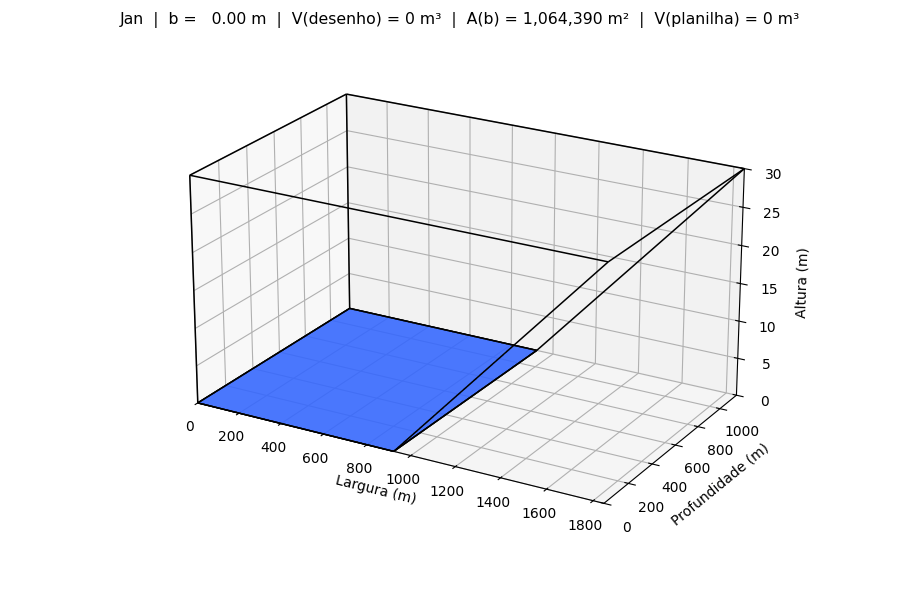


Sem vertimento: nenhum mês excedeu Vmax.


In [10]:
import os, io, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from IPython.display import Image, display

# ---------- checagens ----------
try:
    a, c
except NameError:
    raise RuntimeError("As variáveis 'a' e 'c' não existem. Rode a célula que as define.")

# ---------- escolha COM/SEM P-E ----------
try:
    resp = input("Considerar precipitação/evaporação? [S/N]: ").strip().upper()
except Exception:
    resp = "N"
USE_PE = (resp == "S")

# ---------- caminhos ----------
BASE = r"PEE---2025" # Corrected path to look within the cloned repository directory
ARQ = os.path.join(BASE, "BalancoReservatorio_comPE_.xlsx" if USE_PE
                          else "BalancoReservatorio_semPE_.xlsx")
GIF_PATH = os.path.join(BASE, f"Reservatorio_VolumeAnim_{'comPE' if USE_PE else 'semPE'}.gif")

# fallbacks (Colab/Jupyter): procurar na pasta atual
if not os.path.exists(ARQ):
    alt = [p for p in os.listdir(".")
           if p.lower().endswith(".xlsx")
           and "balancoreservatorio" in p.lower()
           and (("compe" in p.lower()) == USE_PE)]
    if alt:
        ARQ = alt[0]
        GIF_PATH = os.path.join(os.getcwd(), f"Reservatorio_VolumeAnim_{'comPE' if USE_PE else 'semPE'}.gif")
    else:
        raise FileNotFoundError(
            "Não encontrei a planilha esperada. Gere-a na célula anterior ou ajuste o caminho 'ARQ'."
        )

# ---------- leitura ----------
dfb = pd.read_excel(ARQ)
def _col(df, nome):
    alvo = nome.strip().lower()
    for k in df.columns:
        if k.strip().lower() == alvo:
            return k
    raise KeyError(f"Coluna '{nome}' não encontrada. Colunas: {list(df.columns)}")

col_Vi = _col(dfb, "Vi (m3)")
col_Vf = _col(dfb, "Vf (m3)")
Vi = dfb[col_Vi].astype(float).values
Vf = dfb[col_Vf].astype(float).values
if any(c.strip().lower()=="mês" for c in dfb.columns):
    col_MES = _col(dfb, "Mês")
    meses_labels = dfb[col_MES].astype(str).tolist()
else:
    meses_labels = [f"Mês {i+1}" for i in range(len(Vi))]

nmes = len(Vi)

# ---------- geometria (igual) ----------
w0, w1, D = 20.0*c, 40.0*c, 25.0*c
Vmax = 750.0*(c**2)*a

def largura(z):        return 20.0*c*(1.0 + z/a)
def V_de_b(b):         return 500.0*(c**2)*b + (250.0*(c**2)/a)*(b**2)
def b_de_V(V):
    # inverso de V(b); usamos clamp para desenhar
    A = 250.0*(c**2)/a; B = 500.0*(c**2); C = -max(0.0, min(V, Vmax))
    disc = B*B - 4*A*C
    if disc < 0: return 0.0
    r1 = (-B + math.sqrt(disc)) / (2*A)
    r2 = (-B - math.sqrt(disc)) / (2*A)
    return max(0.0, min(max(r1, r2, 0.0), a))
def A_lamina(b):       return 500.0*(c**2)*(1.0 + b/a)

# ---------- vertimento por mês ----------
extravaso = np.maximum(Vf - Vmax, 0.0)   # m³ acima da capacidade no fim do mês
tem_vert = extravaso > 0
total_extravaso = float(extravaso.sum())

# ---------- trajetória Vi→Vf (igual) ----------
FRAMES_POR_MES = 8   # suavidade (4–12)
FPS = 8

V_traj = []
mes_idx_for_frame = []
for i in range(nmes):
    v0, v1 = float(Vi[i]), float(Vf[i])
    for t in np.linspace(0.0, 1.0, FRAMES_POR_MES, endpoint=False):
        V_traj.append((1.0 - t)*v0 + t*v1)
        mes_idx_for_frame.append(i)
# último frame no fim do último mês
V_traj.append(float(Vf[-1]))
mes_idx_for_frame.append(nmes - 1)
N = len(V_traj)

# ---------- casco do reservatório (igual) ----------
bottom = [(0, 0, 0), (w0, 0, 0), (w0, D, 0), (0, D, 0)]
top    = [(0, 0, a), (w1, 0, a), (w1, D, a), (0, D, a)]
edges_res = [
    [bottom[0], bottom[1]], [bottom[1], bottom[2]], [bottom[2], bottom[3]], [bottom[3], bottom[0]],
    [top[0], top[1]], [top[1], top[2]], [top[2], top[3]], [top[3], top[0]],
    [bottom[0], top[0]], [bottom[1], top[1]], [bottom[2], top[2]], [bottom[3], top[3]],
]
def faces_agua_from_b(b):
    wb = largura(b)
    top_b = [(0, 0, b), (wb, 0, b), (wb, D, b), (0, D, b)]
    return [
        bottom, top_b,
        [bottom[0], bottom[1], top_b[1], top_b[0]],
        [bottom[1], bottom[2], top_b[2], top_b[1]],
        [bottom[2], bottom[3], top_b[3], top_b[2]],
        [bottom[3], bottom[0], top_b[0], top_b[3]],
    ]

# ---------- figura e animação (igual) ----------
FIGSIZE = (9.2, 5.9)
VERTICAL_EXAG = 0.65     # mantenho o mesmo comportamento visual que você aprovou

fig = plt.figure(figsize=FIGSIZE, constrained_layout=True)
ax  = fig.add_subplot(111, projection='3d')

poly_agua = Poly3DCollection(faces_agua_from_b(0.0), alpha=0.65, edgecolor='k')
poly_agua.set_facecolor((0.2, 0.4, 1.0, 0.65))
ax.add_collection3d(poly_agua)
ax.add_collection3d(Line3DCollection(edges_res, linewidths=1.1, colors='k'))

ax.set_xlim(0, max(w0, w1)); ax.set_ylim(0, D); ax.set_zlim(0, a)
ax.set_xlabel('Largura (m)'); ax.set_ylabel('Profundidade (m)'); ax.set_zlabel('Altura (m)')
ax.view_init(elev=22, azim=-60)

bx, by = max(w0, w1), D
bz = max(a, VERTICAL_EXAG*(bx+by)/2)
ax.set_box_aspect((bx, by, bz))

def set_header(V_planilha, mes_idx):
    # clamp para desenhar
    Vc = max(0.0, min(V_planilha, Vmax))
    b  = b_de_V(Vc)
    titulo = (f"{meses_labels[mes_idx]}  |  b = {b:6.2f} m"
              f"  |  V(desenho) = {V_de_b(b):,.0f} m³"
              f"  |  A(b) = {A_lamina(b):,.0f} m²"
              f"  |  V(planilha) = {V_planilha:,.0f} m³")
    if extravaso[mes_idx] > 0:
        titulo += f"  |  **VERTIMENTO: {extravaso[mes_idx]:,.0f} m³**"
    fig.suptitle(titulo, fontsize=11.3, y=0.98)

def init():
    set_header(V_traj[0], mes_idx_for_frame[0])
    b = b_de_V(max(0.0, min(V_traj[0], Vmax)))
    poly_agua.set_verts(faces_agua_from_b(b))
    return (poly_agua,)

def update(i):
    V_now = V_traj[i]
    mi = mes_idx_for_frame[i]
    Vc = max(0.0, min(V_now, Vmax))
    b  = b_de_V(Vc)
    poly_agua.set_verts(faces_agua_from_b(b))
    set_header(V_now, mi)
    return (poly_agua,)

anim = animation.FuncAnimation(fig, update, init_func=init, frames=N, interval=int(1000/FPS), blit=True)

# ---------- salvar GIF e exibir ----------
try:
    os.makedirs(os.path.dirname(GIF_PATH), exist_ok=True)
except Exception:
    GIF_PATH = os.path.join(os.getcwd(), f"Reservatorio_VolumeAnim_{'comPE' if USE_PE else 'semPE'}.gif")

anim.save(GIF_PATH, writer=animation.PillowWriter(fps=FPS))
plt.close(fig)
print(f"GIF salvo em: {GIF_PATH}")
display(Image(filename=GIF_PATH))

# ---------- mensagens de vertimento ----------
if tem_vert.any():
    print("\n>>> VERTIMENTO DETECTADO:")
    for i, extr in enumerate(extravaso):
        if extr > 0:
            print(f"- {meses_labels[i]}: extravaso = {extr:,.2f} m³ (Vf={Vf[i]:,.2f} > Vmax={Vmax:,.2f})")
    print(f"Total extravasado no ano: {total_extravaso:,.2f} m³")
else:
    print("\nSem vertimento: nenhum mês excedeu Vmax.")

Animação do reservatório sem extravasaemento de água, mesmo chegando a 100% do volume total.
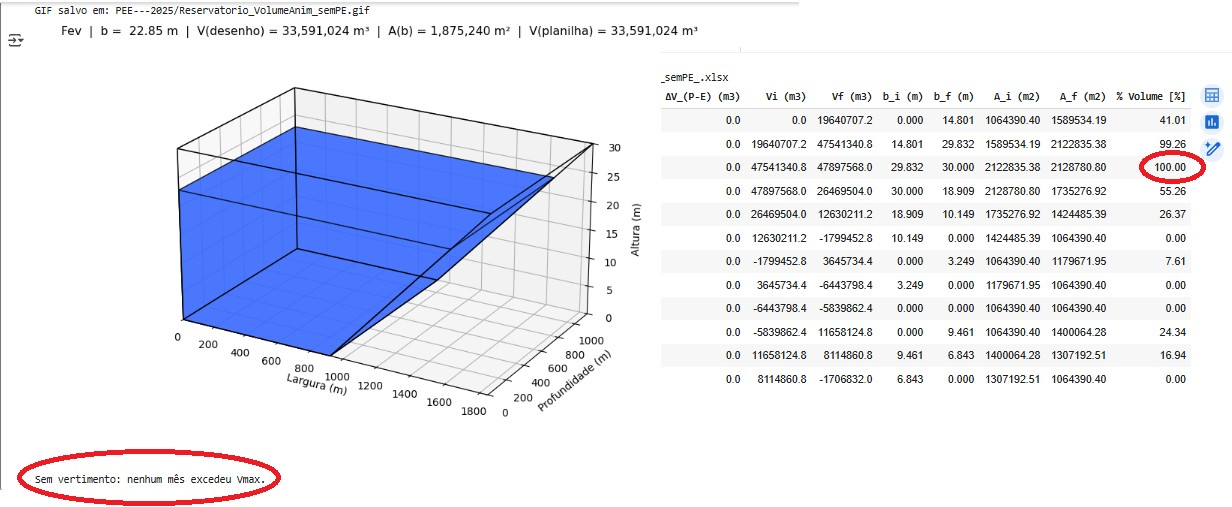

A rotina seguinte determina a queda líquida nominal de referência a partir da curva de permanência da série \(HB\) (altura bruta corrigida), de modo que o gerador forneça a potência nominal em 95\% do tempo (usa-se \($HB_{Q95}$\)).

###### Arquivos e parâmetros
- Entrada: `BalancoReservatorio_semPE_.xlsx` (coluna `b_f (m)`)
- Saída: `HB_Permanencia.xlsx` (abas `Permanencia` e `Quantis`; *fallback* para CSVs)
- Constante: \$(HB_{\max} = 45m\$)

##### Etapas do processamento

1. Leitura da série \(b_f\) (m):
   Lê a coluna `b_f (m)`.

2. Ajuste por deslocamento \(k\) e construção de \(HB\):
   Deslocamento para limitar a série a \$(HB_{\max}$\):
   $$k = HB_{\max} - \max(b_f)$$
   Série corrigida:
   $$HB_{i} = b_{f,i} + k$$

3. Curva de permanência (excedência):
   Ordena \(HB\) de forma decrescente e determina a probabilidade de permanência para \$(i = 1, \ldots, n$\):
   $$P_{i} = \frac{i}{n+1} \times 100\%$$

4. Quantis de interesse (Q50, Q75, Q95)
   Computa \(HB\) nos quantis de excedência \(\{50, 75, 95\}\%\):
   $$HB_{Qx} = \mathrm{Percentil}(HB,\,100-x)$$
   
   Em particular, a queda de referência inicial para o projeto será \$(HB_{Q95}$\).

5. Gráfico
   Plota \$(HB_{\mathrm{sorted}}\) vs. \(P$\) (curva de permanência) e marca os pontos Q50, Q75 e Q95.

6. Tabelas e exportação
   - Permanencia: tabela com \$(P\) (em \%) e \(HB_{\mathrm{sorted}}$\) (m).
   - Quantis: resumo de \(HB\) para Q50, Q75 e Q95.
   Salva em `HB_Permanencia.xlsx`.

##### Saída principal para seleção de turbina
- Queda líquida nominal de referência: \(HB_{Q95}\) (m), proveniente da curva de permanência.

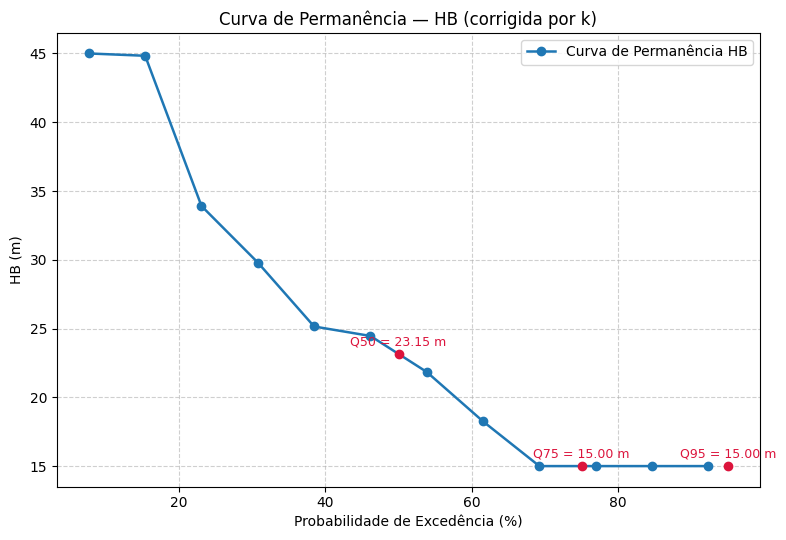


HBmax = 45.00 m | max(b_f) = 30.00 m | k = 15.000 m

Quantis HB:
Quantil  HB (m)
    Q50  23.152
    Q75  15.000
    Q95  15.000

Arquivo Excel salvo em: /content/PEE---2025/HB_Permanencia.xlsx


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

HBMAX = 45.0  # m
BASE_DIR = r"/content/PEE---2025/" # Corrected path
ARQ_IN  = os.path.join(BASE_DIR, "BalancoReservatorio_semPE_.xlsx")
ARQ_OUT = os.path.join(BASE_DIR, "HB_Permanencia.xlsx")

def _col(df, nome):
    alvo = nome.strip().lower()
    for k in df.columns:
        if k.strip().lower() == alvo:
            return k
    raise KeyError(f"Coluna '{nome}' não encontrada. Colunas: {list(df.columns)}")

# ----- localizar arquivo (fallback p/ pasta atual) -----
if not os.path.exists(ARQ_IN):
    cand = [p for p in os.listdir(".") if p.lower() == "balancoreservatorio_sempe_.xlsx"]
    if cand:
        ARQ_IN = cand[0]
        ARQ_OUT = os.path.join(os.getcwd(), "HB_Permanencia.xlsx")
    else:
        raise FileNotFoundError("Não encontrei 'BalancoReservatorio_semPE_.xlsx'.")

# ----- leitura -----
df = pd.read_excel(ARQ_IN)
col_bf = _col(df, "b_f (m)")
bf = pd.to_numeric(df[col_bf], errors="coerce").dropna().to_numpy(dtype=float)
if bf.size == 0:
    raise ValueError("A coluna 'b_f (m)' não contém valores numéricos válidos.")

# ----- ajuste por k -----
k = HBMAX - float(np.nanmax(bf))
HB = bf + k

# ----- curva de permanência -----
HB_sorted   = np.sort(HB)[::-1]
n           = len(HB_sorted)
exceed_prob = (np.arange(1, n+1) / (n+1)) * 100.0  # %

# ----- quantis (excedência) -----
quantis     = [50, 75, 95]  # em %
HB_quantis  = np.percentile(HB, [100 - q for q in quantis])

# ----- gráfico -----
plt.figure(figsize=(8, 5.5))
plt.plot(exceed_prob, HB_sorted, marker="o", lw=1.8, label="Curva de Permanência HB")
for q, hq in zip(quantis, HB_quantis):
    plt.scatter(q, hq, color="crimson", zorder=5)
    plt.text(q, hq + 0.6, f"Q{q} = {hq:.2f} m", color="crimson", ha="center", fontsize=9)
plt.xlabel("Probabilidade de Excedência (%)")
plt.ylabel("HB (m)")
plt.title("Curva de Permanência — HB (corrigida por k)")
plt.grid(True, ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ----- tabelas -----
tab_perm = pd.DataFrame({"Excedência (%)": np.round(exceed_prob, 2),
                         "HB_sorted (m)":  np.round(HB_sorted, 3)})
tab_quantis = pd.DataFrame({"Quantil": [f"Q{q}" for q in quantis],
                            "HB (m)":  np.round(HB_quantis, 3)})

print(f"\nHBmax = {HBMAX:.2f} m | max(b_f) = {np.max(bf):.2f} m | k = {k:.3f} m")
print("\nQuantis HB:")
print(tab_quantis.to_string(index=False))

# ----- salvar em Excel
try:
    os.makedirs(os.path.dirname(ARQ_OUT), exist_ok=True)
except Exception:
    ARQ_OUT = os.path.join(os.getcwd(), "HB_Permanencia.xlsx")

try:
    # tenta com openpyxl
    with pd.ExcelWriter(ARQ_OUT, engine="openpyxl") as xlw:
        tab_perm.to_excel(xlw, index=False, sheet_name="Permanencia")
        tab_quantis.to_excel(xlw, index=False, sheet_name="Quantis")
    print(f"\nArquivo Excel salvo em: {ARQ_OUT}")
except Exception as e:
    # fallback para CSVs
    csv1 = os.path.join(os.path.dirname(ARQ_OUT), "HB_Permanencia_Permanencia.csv")
    csv2 = os.path.join(os.path.dirname(ARQ_OUT), "HB_Permanencia_Quantis.csv")
    tab_perm.to_csv(csv1, index=False, encoding="utf-8")
    tab_quantis.to_csv(csv2, index=False, encoding="utf-8")
    print("\n(openpyxl/xlsxwriter indisponível) Salvei como CSV:")
    print(f" - {csv1}")
    print(f" - {csv2}")

Os valores obrtidos para a curva de não permanência HB obtidos na rotina, correspondem com os determinados teoricamente. Ou seja, HB_q95=15m

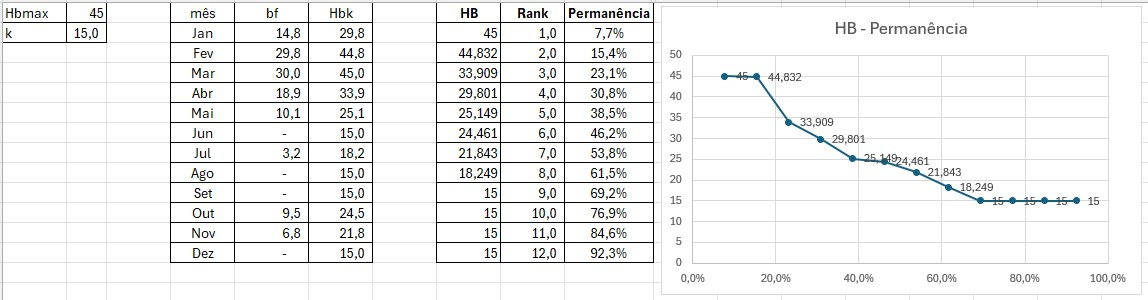

## Definição da Turbina



#### Arquivos e parâmetros
- Entradas
  - `Reservatorio_1.xlsx` → lê \(Q_{\text{médio}}\) da célula C2  
  - `BalancoReservatorio_comPE_.xlsx` → lê a coluna `b_f (m)`  
- Saída  
  - `Selecao_Turbinas.xlsx` (com *fallback* para CSVs)  
- Parâmetro de projeto
  - \($HB_{\max} = 45\,\ {m}$\)

#### Etapas do processamento
1. Leitura de arquivos e colunas
   Leitura de \$Q__ médio\
   Obtido da célula C2 de `Reservatorio_1.xlsx`.
3. Construção da série \(HB\)  
   Lê o vetor \(b_f\) (m). Calcula  
   $$k = HB_{\max} - \max(b_f)$$  
   e aplica *clipping*:  
   $$HB_i=\operatorname{clip}(b_{f,i}+k,\,0,\,HB_{\max}).$$
4. Altura de projeto
   Percentil 5:  
   $$HB_{Q95}=\min\!\big(P_{5}(HB),\,HB_{\max}\big).$$
5. Tabela típica (faixas \(H\times Q\)  
   Tipos: Pelton, Francis, Francis Casa Aberta, Kaplan (S/hélice), Bulbo; cada um com \$((H_{\min},H_{\max},Q_{\min},Q_{\max})$\).
6. Seleção de turbinas aplicáveis
   Critério:  
   $$H_{\min}\le H \le H_{\max},\quad Q_{\min}\le Q \le Q_{\max}.$$  
   Se nenhuma se aplica, ranqueia pela distância log–log:  
   $$\text{Score}=\sqrt{(\log_{10}H-\log_{10}H_c)^2+(\log_{10}Q-\log_{10}Q_c)^2}.$$
7. Nomograma \(H\times Q\)
   Gráfico log–log dos envelopes e ponto de projeto \((Q,H)\).
8. Exportação
   Gera `Selecao_Turbinas.xlsx.


=== Parâmetros de Projeto ===
Q_médio = 27.267 m³/s  (Reservatorio_1.xlsx C2)
HB_Q95  = 17.370 m  |  HBmax = 45.00 m  |  k = 17.370 m

=== Tabela típica de aplicação (H × Q) ===


,Turbina,H_min (m),H_max (m),Q_min (m3/s),Q_max (m3/s),Observações
0,Pelton,50,1000,0.1,20,"Altas quedas, baixas vazões (múltiplos jatos)"
1,Francis,20,300,1.0,200,"Versátil, quedas médias"
2,Francis Casa Aberta,10,60,1.0,50,Variante para quedas mais baixas
3,Kaplan (S/hélice),2,30,10.0,1000,"Baixa queda, alta vazão"
4,Bulbo c/ Multiplicador,2,20,20.0,2000,"Fio d’água, quedas muito baixas"



=== Turbinas aplicáveis ao projeto ===


,Turbina,H_min (m),H_max (m),Q_min (m3/s),Q_max (m3/s),Observações
0,Francis Casa Aberta,10,60,1.0,50,Variante para quedas mais baixas
1,Kaplan (S/hélice),2,30,10.0,1000,"Baixa queda, alta vazão"
2,Bulbo c/ Multiplicador,2,20,20.0,2000,"Fio d’água, quedas muito baixas"


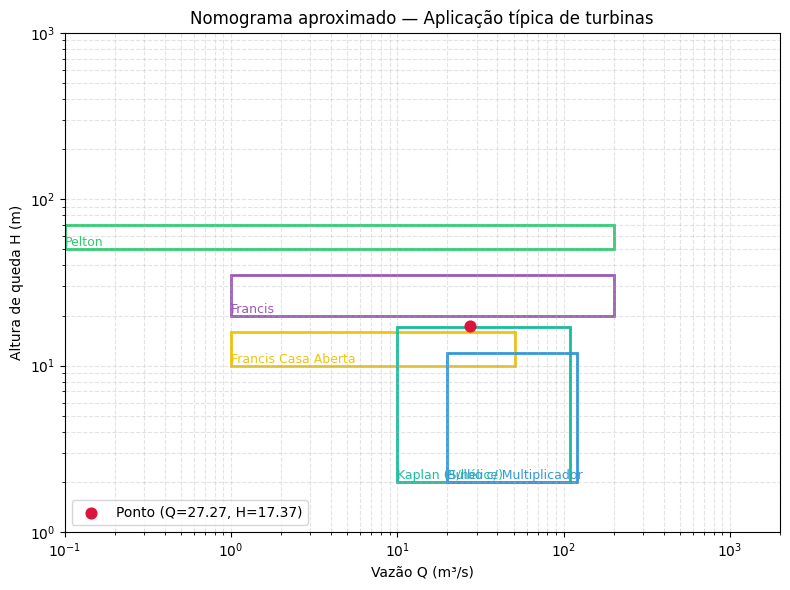


Arquivo Excel salvo em: PEE---2025/Selecao_Turbinas.xlsx


In [ ]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ---------------- Caminhos ----------------
BASE   = r"PEE---2025" # Corrected path
ARQ_Q  = os.path.join(BASE, "Reservatorio_1.xlsx")
ARQ_BF = os.path.join(BASE, "BalancoReservatorio_comPE_.xlsx")
ARQ_OUT= os.path.join(BASE, "Selecao_Turbinas.xlsx")

HBMAX = 45.0  # ---> DEFINIÇÃO DE PROJETO (ALTURA MÁXIMA)

def _fallback(expected, exact_lower):
    if os.path.exists(expected):
        return expected
    cand = [p for p in os.listdir(".") if p.lower() == exact_lower]
    if cand:
        return cand[0]
    return expected

def _col(df, nome):
    alvo = nome.strip().lower()
    for k in df.columns:
        if k.strip().lower() == alvo:
            return k
    raise KeyError(f"Coluna '{nome}' não encontrada. Colunas: {list(df.columns)}")

ARQ_Q  = _fallback(ARQ_Q,  "reservatorio_1.xlsx")
ARQ_BF = _fallback(ARQ_BF, "balancoreservatorio_compe_.xlsx")

# -------- 1) Ler Q_médio (B2) --------
if not os.path.exists(ARQ_Q):
    raise FileNotFoundError(f"Não encontrei o arquivo: {ARQ_Q}")
sheet_q = pd.read_excel(ARQ_Q, header=None)
Q_medio = float(sheet_q.iat[1, 2])  # C2

# -------- 2) Série HB a partir de b_f (m) com k e LIMITE HBMAX --------
if not os.path.exists(ARQ_BF):
    raise FileNotFoundError(f"Não encontrei o arquivo: {ARQ_BF}")
df_b = pd.read_excel(ARQ_BF)
col_bf = _col(df_b, "b_f (m)")
bf = pd.to_numeric(df_b[col_bf], errors="coerce").dropna().to_numpy(float)
if bf.size == 0:
    raise ValueError("A coluna 'b_f (m)' não contém números válidos.")

# Centraliza a série para que o máximo coincida com HBMAX e CLIPA em [0, HBMAX]
k  = HBMAX - float(np.nanmax(bf))
HB = np.clip(bf + k, 0.0, HBMAX)

# HB_Q95 (excedência 95% -> percentil 5), garantindo <= HBMAX
HB_Q95 = float(np.percentile(HB, 5))
HB_Q95 = min(HB_Q95, HBMAX)

# -------- 3) Tabela típica (faixas H × Q) --------
turbinas = pd.DataFrame([
    ["Pelton",                 50, 1000,   0.1,    20,    "Altas quedas, baixas vazões (múltiplos jatos)"],
    ["Francis",                20,  300,   1.0,   200,    "Versátil, quedas médias"],
    ["Francis Casa Aberta",    10,   60,   1.0,    50,    "Variante para quedas mais baixas"],
    ["Kaplan (S/hélice)",       2,   30,  10.0,  1000,    "Baixa queda, alta vazão"],
    ["Bulbo c/ Multiplicador",  2,   20,  20.0,  2000,    "Fio d’água, quedas muito baixas"],
], columns=["Turbina", "H_min (m)", "H_max (m)", "Q_min (m3/s)", "Q_max (m3/s)", "Observações"])

# -------- 4) Turbinas aplicáveis --------
H = HB_Q95
Q = Q_medio
mask = (H >= turbinas["H_min (m)"]) & (H <= turbinas["H_max (m)"]) & \
       (Q >= turbinas["Q_min (m3/s)"]) & (Q <= turbinas["Q_max (m3/s)"])
aplicaveis = turbinas[mask].reset_index(drop=True)

print("=== Parâmetros de Projeto ===")
print(f"Q_médio = {Q:.3f} m³/s  (Reservatorio_1.xlsx C2)")
print(f"HB_Q95  = {H:.3f} m  |  HBmax = {HBMAX:.2f} m  |  k = {k:.3f} m\n")

print("=== Tabela típica de aplicação (H × Q) ===")
display(turbinas)

if aplicaveis.empty:
    # Sugestão ranqueada (distância em log-space ao envelope)
    import math
    def _dist_log_rect(Hv, Qv, row):
        Hmin, Hmax = row["H_min (m)"], row["H_max (m)"]
        Qmin, Qmax = row["Q_min (m3/s)"], row["Q_max (m3/s)"]
        Hc = min(max(Hv, Hmin), Hmax)
        Qc = min(max(Qv, Qmin), Qmax)
        return math.hypot(math.log10(Hv) - math.log10(Hc),
                          math.log10(Qv) - math.log10(Qc))

    sugestoes = turbinas.copy()
    sugestoes["Score (↓ melhor)"] = sugestoes.apply(lambda r: _dist_log_rect(H, Q, r), axis=1)
    sugestoes = sugestoes.sort_values("Score (↓ melhor)").reset_index(drop=True)

    print("\nNenhuma turbina enquadrou simultaneamente H e Q.")
    print("Sugestão ranqueada (menor distância log-HQ ao envelope):")
    display(sugestoes)
else:
    print("\n=== Turbinas aplicáveis ao projeto ===")
    display(aplicaveis[["Turbina","H_min (m)","H_max (m)","Q_min (m3/s)","Q_max (m3/s)","Observações"]])

# -------- 5) Nomograma aproximado (log–log) --------
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlim(0.1, 2000); ax.set_ylim(1, 1000)
ax.set_xlabel("Vazão Q (m³/s)")
ax.set_ylabel("Altura de queda H (m)")
ax.set_title("Nomograma aproximado — Aplicação típica de turbinas")

colors = {
    "Pelton": "#2ecc71",
    "Francis": "#9b59b6",
    "Francis Casa Aberta": "#f1c40f",
    "Kaplan (S/hélice)": "#1abc9c",
    "Bulbo c/ Multiplicador": "#3498db",
}
for _, r in turbinas.iterrows():
    x, y = r["Q_min (m3/s)"], r["H_min (m)"]
    w = r["Q_max (m3/s)"] / r["Q_min (m3/s)"]
    h = r["H_max (m)"] / r["H_min (m)"]
    rect = Rectangle((x, y), w, h, fill=False, lw=2,
                     edgecolor=colors.get(r["Turbina"], "k"),
                     transform=ax.transData)
    ax.add_patch(rect)
    ax.text(x, y, r["Turbina"], color=colors.get(r["Turbina"], "k"),
            fontsize=9, va="bottom", ha="left")

# Ponto de projeto (com HB limitado a 45 m)
ax.scatter([Q], [H], s=60, c="crimson", zorder=5, label=f"Ponto (Q={Q:.2f}, H={H:.2f})")
ax.legend(loc="lower left")
ax.grid(True, which="both", ls="--", alpha=0.35)
plt.tight_layout()
plt.show()

# -------- 6) Salvar Excel --------
parametros = pd.DataFrame({
    "Parametro": ["Q_medio (m3/s)", "HB_Q95 (m)", "k (m)", "HBmax (m)"],
    "Valor":     [Q, H, k, HBMAX]
})
hb_serie = pd.DataFrame({"HB (m)": np.round(HB, 3)})

try:
    os.makedirs(os.path.dirname(ARQ_OUT), exist_ok=True)
except Exception:
    ARQ_OUT = os.path.join(os.getcwd(), "Selecao_Turbinas.xlsx")

try:
    with pd.ExcelWriter(ARQ_OUT, engine="openpyxl") as xlw:
        turbinas.to_excel(xlw, index=False, sheet_name="Tabela_Tipica")
        (aplicaveis if not aplicaveis.empty else turbinas.iloc[0:0]).to_excel(
            xlw, index=False, sheet_name="Aplicaveis"
        )
        parametros.to_excel(xlw, index=False, sheet_name="Parametros")
        hb_serie.to_excel(xlw, index=False, sheet_name="HB_Serie")
    print(f"\nArquivo Excel salvo em: {ARQ_OUT}")
except Exception as e:
    # fallback CSVs
    base_dir = os.path.dirname(ARQ_OUT) or "."
    p1 = os.path.join(base_dir, "Selecao_Turbinas_TabelaTipica.csv")
    p2 = os.path.join(base_dir, "Selecao_Turbinas_Aplicaveis.csv")
    p3 = os.path.join(base_dir, "Selecao_Turbinas_Parametros.csv")
    p4 = os.path.join(base_dir, "Selecao_Turbinas_HB_Serie.csv")
    turbinas.to_csv(p1, index=False, encoding="utf-8")
    (aplicaveis if not aplicaveis.empty else turbinas.iloc[0:0]).to_csv(p2, index=False, encoding="utf-8")
    parametros.to_csv(p3, index=False, encoding="utf-8")
    hb_serie.to_csv(p4, index=False, encoding="utf-8")
    print("\n(openpyxl indisponível) Salvei como CSV:")
    print(" -", p1)
    print(" -", p2)
    print(" -", p3)
    print(" -", p4)

A rotina a seguir determina as perdas hidráulicas básicas, a altura disponível e a potência hidráulica da turbina a partir da altura bruta \$(HB\) (idealmente \(HB_{Q95}\$) e da vazão média \$(Q_{\mathrm{medio}}$\).

#### Parâmetros e entradas
- Constantes: \(z = 0,025\) (2,5\%) e \(N = 0,86\).
- Entradas: \(HB) (m) e \$(Q_{\mathrm{medio}}) (m^3$/s).
  
#### Etapas do cálculo

1. Perda na tomada de água
   
   $$\mathrm{Perda\_tomada} = z \cdot HB$$

2. Perda na adução  (aplica \((1-N)\) à altura remanescente)
   
   $$\mathrm{Perda\_aducao} = \bigl(HB - \mathrm{Perda\_tomada}\bigr)\,(1 - N)$$

3. Altura disponível para geração
   
   $$\mathrm{Altura\_disponivel} = HB - \bigl(\mathrm{Perda\_tomada} + \mathrm{Perda\_aducao}\bigr)$$

4. Potência hidráulica
   
   Em **cv**:
   $$P_{\mathrm{hid}}^{(\mathrm{cv})} = \left(\frac{1000 \cdot Q_{\mathrm{medio}}}{75}\right)\,\mathrm{Altura\_disponivel}$$
   
   Em **MW** \$((1\ \mathrm{cv} = 0{,}000735\mathrm{MW}):
   $$P_{\mathrm{hid}}^{(\mathrm{MW})} = 0{,}000735 \cdot P_{\mathrm{hid}}^{(\mathrm{cv})}$

#### Saídas:
- \$(HB\) (m), \(Q_{\mathrm{medio}}\) (m^3$/s)

- \$\mathrm{Perda\ tomada}\ (m), \mathrm{Perda\ aducao}$ (m)

- \$\mathrm{Altura\ disponivel}$\) (m)

- \$(P_{\mathrm{hid}}^{(\mathrm{cv})}\) (cv) e \(P_{\mathrm{hid}}^{(\mathrm{MW})}$\) (MW)


In [ ]:
# Parâmetros fixos
z = 0.025   # 2,5% (perda na tomada d´água)
N = 0.86    # (rendimento na canalização)

# Tenta usar variáveis já existentes; se não houver, pede via input
def _get_var(name, prompt):
    try:
        return float(globals()[name])
    except Exception:
        while True:
            try:
                return float(input(prompt).replace(",", "."))
            except Exception:
                print("Valor inválido. Tente novamente.")

HB = _get_var("HB_Q95", "Informe HB (m): ")
Q_medio = _get_var("Q_medio", "Informe Q_medio (m³/s): ")

# Cálculos
perda_tomada = z * HB
perda_aducao = (HB - perda_tomada) * (1 - N)
altura_disp  = HB - (perda_tomada + perda_aducao)
pot_hid_cv   = (1000.0 * Q_medio/75) * altura_disp
pot_hid_mw   = pot_hid_cv*0.000735

# Impressão formatada
print("=== Resultados ===")
print(f"HB (altura bruta)                    : {HB:,.3f} m")
print(f"Q_medio (vazão média)                : {Q_medio:,.3f} m³/s")
print(f"Perda na tomada de água (z=2,5%)     : {perda_tomada:,.3f} m")
print(f"Perda na tubulação de adução (N=0,75): {perda_aducao:,.3f} m")
print(f"Altura disponível                     : {altura_disp:,.3f} m")
print(f"Potência hidráulica (cv)              : {pot_hid_cv:,.3f} cv")
print(f"Potência hidráulica (MW)              : {pot_hid_mw:,.3f} MW")

=== Resultados ===
HB (altura bruta)                    : 17.370 m
Q_medio (vazão média)                : 27.267 m³/s
Perda na tomada de água (z=2,5%)     : 0.434 m
Perda na tubulação de adução (N=0,75): 2.371 m
Altura disponível                     : 14.565 m
Potência hidráulica (cv)              : 5,295.094 cv
Potência hidráulica (MW)              : 3.892 MW


A rotina seguinte determina o intervalo de velocidade específica para uma turbina Francis em função da altura disponível.

##### Relações e parâmetros
- Definição (Francis):
  $$n_s \;=\; \frac{A_{\text{Francis}}}{\sqrt{H_{\text{TOP}}}}$$
- Faixa típica:
  $$A_{\text{Francis}} \in [1530,\; 2330]$$

##### Entradas
- \$(H_{\text{TOP}}\)= altura\ disp$

##### Etapas do cálculo
1. Intervalo recomendado de \(n_s\)  
   - Extremos calculados com a faixa padrão de (A_Francis\):  
     $$n_{s,\min}=\frac{1530}{\sqrt{H_{\text{TOP}}}}, \qquad
       n_{s,\max}=\frac{2330}{\sqrt{H_{\text{TOP}}}}$$
3. (Opcional) \(n_s\) pontual  
   - Se o usuário fornecer \$(A_{\text{Francis}}$\), então:  
     $$n_s \=\ \frac{A_{\text{Francis}}}{\sqrt{H_{\text{TOP}}}}$$

##### Saídas
- \$(H_{\text{TOP}}=altura\ disponivel)$ em m.  
- Faixa (A_Francis): \(1530 a 2330\)
- Intervalo recomendado de \(n_s\) (rpm): \[n_s min; n_s max}]\.  
- (Opcional) \(n_s\) pontual para o (A_Francis) informado.


In [ ]:
import math

A_MIN = 1530.0
A_MAX = 2330.0

# --- Obtém H_TOP = altura_disp do ambiente ou pergunta ao usuário ---
def _get_HB():
    # Verifica se 'altura_disp' existe
    if 'altura_disp' in globals() and isinstance(globals()['altura_disp'], (int, float)) and globals()['altura_disp'] > 0:
        val = float(globals()['altura_disp'])
        print(f"Usando altura_disp = {val:.3f} m como H_TOP.")
        return val
       # Se não existir, pergunta ao usuário
    else:
        while True:
            try:
                return float(input("Informe H_TOP (= Altura Disponível ou HB_Q95) em m: ").replace(",", "."))
            except ValueError:
                print("Valor inválido. Tente novamente.")


H_TOP = _get_HB()

# --- Intervalo recomendado de n_s ---
if H_TOP <= 0:
     raise ValueError("H_TOP must be a positive value.")

ns_min = A_MIN / math.sqrt(H_TOP)
ns_max = A_MAX / math.sqrt(H_TOP)

print("\n=== Velocidade específica — Intervalo recomendado (Francis) ===")
print(f"H_TOP (=Altura Disponível)            : {H_TOP:.3f} m")
print(f"A_Francis (mín..máx)   : {A_MIN:.0f} .. {A_MAX:.0f}")
print(f"n_s recomendado (rpm)  : {ns_min:.1f} .. {ns_max:.1f} rpm")

# --- (Opcional) calcular n_s pontual se A_Francis for conhecido ---
try:
    a_str = input("\nDeseja informar A_Francis para calcular n_s pontual? (vazio para pular) ")
    if a_str.strip():
        A_user = float(a_str.replace(",", "."))
        if A_user > 0:
            ns_user = A_user / math.sqrt(H_TOP)
            print(f"n_s (A_Francis = {A_user:.1f}) : {ns_user:.1f} rpm")
        else:
            print("Valor de A_Francis deve ser positivo.")
except ValueError:
    print("Entrada inválida para A_Francis.")
except Exception:
    pass # Ignore other potential errors during input

Usando altura_disp = 14.565 m como H_TOP.

=== Velocidade específica — Intervalo recomendado (Francis) ===
H_TOP (=Altura Disponível)            : 14.565 m
A_Francis (mín..máx)   : 1530 .. 2330
n_s recomendado (rpm)  : 400.9 .. 610.5 rpm

Deseja informar A_Francis para calcular n_s pontual? (vazio para pular) 


A rotina a seguir dimensiona o número de polos, a rotação síncrona, as potências (totais e por máquina) e a corrente nominal em 13,8 kV, a partir da altura disponível \(H\), da potência hidráulica total e da faixa de velocidade específica. O usuário informa o número de máquinas.


Falta complementar


In [ ]:
import os, math
import numpy as np
import pandas as pd

ETA_TURB = 0.90      # rendimento turbina (hidráulica -> mecânica)
ETA_GEN  = 0.95      # rendimento gerador  (mecânica -> elétrica)
CV2MW    = 0.0007347 # 1 cv em MW
PF       = 1      # fator de potência para kVA
V_LL_kV  = 13.8      # tensão de linha (kV)
V_LL     = V_LL_kV * 1000.0  # V

# --------- helpers ---------
def _need(name, prompt=None):
    if name in globals():
        try:
            return float(globals()[name])
        except Exception:
            pass
    if prompt is None:
        raise RuntimeError(f"Variável '{name}' não encontrada.")
    while True:
        try:
            return float(input(prompt).replace(",", "."))
        except Exception:
            print("Valor inválido. Tente novamente.")

def _need_range(lo="ns_min", hi="ns_max"):
    if lo in globals() and hi in globals():
        lo_v = float(globals()[lo]); hi_v = float(globals()[hi])
        if lo_v > 0 and hi_v > 0 and hi_v >= lo_v:
            return lo_v, hi_v
    lo_v = _need(lo, "Informe ns_min (rpm): ")
    hi_v = _need(hi, "Informe ns_max (rpm): ")
    return lo_v, hi_v

# --------- entradas do ambiente ---------
H        = _need("altura_disp", "Informe altura_disp (m): ")
P_hid_cv = _need("pot_hid_cv",  "Informe pot_hid_cv (cv): ")
ns_min, ns_max = _need_range("ns_min", "ns_max")

# --------- nº de máquinas ---------
while True:
    try:
        Nmaq = int(input("Informe o número de máquinas (inteiro > 2): ").strip())
        if Nmaq > 2:
            break
        print("O número de máquinas deve ser > 2.")
    except Exception:
        print("Entrada inválida. Digite um inteiro, ex.: 3, 4, 5...")

# --------- potências totais ---------
P_mec_total_cv = ETA_TURB * P_hid_cv
P_ele_total_cv = ETA_GEN  * P_mec_total_cv
P_mec_total_MW = P_mec_total_cv * CV2MW
P_ele_total_MW = P_ele_total_cv * CV2MW
S_total_kVA    = (P_ele_total_MW * 1000.0) / PF  # kW/PF = kVA

# Corrente nominal total (trifásico)
I_total_A      = (S_total_kVA * 1000.0) / (math.sqrt(3.0) * V_LL)  # A

# --------- potências por unidade ---------
P_mec_cv = P_mec_total_cv / Nmaq
P_ele_cv = P_ele_total_cv / Nmaq
P_mec_MW = P_mec_cv * CV2MW
P_ele_MW = P_ele_cv * CV2MW
S_kVA    = (P_ele_MW * 1000.0) / PF

# Corrente nominal por máquina
I_A      = (S_kVA * 1000.0) / (math.sqrt(3.0) * V_LL)

# --------- faixa de rotação nT por máquina ---------
def nT_from_ns(ns, H, Pcv):
    return ns * (H**1.25) / math.sqrt(Pcv)

nT_lo  = nT_from_ns(ns_min, H, P_mec_cv)
nT_hi  = nT_from_ns(ns_max, H, P_mec_cv)
nT_mid = 0.5*(nT_lo + nT_hi)

# --------- polos síncronos (n = 7200/p) ---------
p_min = math.ceil(7200.0 / nT_hi)
p_max = math.floor(7200.0 / nT_lo)
p_sel = p_min if p_min % 2 == 0 else p_min + 1
dentro = True
if p_sel > p_max:
    dentro = False  # fora da faixa; primeiro par acima
n_sync = 7200.0 / p_sel

# --------- impressão em tela ---------
print("\n=== ENTRADAS ===")
print(f"Altura disponível (H)               : {H:,.3f} m")
print(f"Potência hidráulica TOTAL           : {P_hid_cv:,.3f} cv  |  {P_hid_cv*CV2MW:,.3f} MW")
print(f"Número de máquinas                  : {Nmaq}")
print(f"Tensão de linha (V_LL)              : {V_LL_kV:.1f} kV")

print("\n=== POTÊNCIAS (TOTAIS) ===")
print(f"Potência mecânica TOTAL (0,90)      : {P_mec_total_cv:,.3f} cv  |  {P_mec_total_MW:,.3f} MW")
print(f"Potência elétrica TOTAL  (0,95)     : {P_ele_total_cv:,.3f} cv  |  {P_ele_total_MW:,.3f} MW")
print(f"Potência aparente TOTAL (fp={PF:.2f}): {S_total_kVA:,.2f} kVA")
print(f"Corrente nominal TOTAL              : {I_total_A:,.1f} A @ {V_LL_kV:.1f} kV")

print("\n=== POTÊNCIAS/CORRENTE (POR MÁQUINA) ===")
print(f"Potência mecânica por máquina       : {P_mec_cv:,.3f} cv  |  {P_mec_MW:,.3f} MW")
print(f"Potência elétrica por máquina       : {P_ele_cv:,.3f} cv  |  {P_ele_MW:,.3f} MW")
print(f"Potência aparente por máquina       : {S_kVA:,.2f} kVA  (fp={PF:.2f})")
print(f"Corrente nominal por máquina        : {I_A:,.1f} A @ {V_LL_kV:.1f} kV")

print("\n=== ROTAÇÃO E POLOS — POR MÁQUINA (60 Hz) ===")
print(f"Faixa de n_s (rpm)                  : {ns_min:,.1f} .. {ns_max:,.1f} rpm")
print(f"Faixa desejada de n_T (rpm)         : {nT_lo:,.1f} .. {nT_hi:,.1f} rpm")
print(f"Intervalo possível de polos (p)     : {p_min} .. {p_max} (pares)")
print(f"Polos selecionados (menor par)      : {p_sel} polos")
print(f"n síncrona por máquina              : {n_sync:,.1f} rpm "
      + ("(dentro da faixa ✅)" if dentro and (nT_lo <= n_sync <= nT_hi) else "(fora da faixa ⚠️)"))

# --------- planilhas para exportação ---------
df_total = pd.DataFrame({
    "Grandeza": [
        "H (m)", "Nº máquinas", "V_LL (kV)",
        "Pot. hidráulica TOTAL (cv)", "Pot. hidráulica TOTAL (MW)",
        "Pot. mecânica TOTAL (cv)",   "Pot. mecânica TOTAL (MW)",
        "Pot. elétrica TOTAL (cv)",   "Pot. elétrica TOTAL (MW)",
        f"Pot. aparente TOTAL (kVA) (fp={PF:.2f})",
        "Corrente nominal TOTAL (A)"
    ],
    "Valor": [
        H, Nmaq, V_LL_kV,
        P_hid_cv, P_hid_cv*CV2MW,
        P_mec_total_cv, P_mec_total_MW,
        P_ele_total_cv, P_ele_total_MW,
        S_total_kVA,
        I_total_A
    ]
})

df_unit = pd.DataFrame({
    "Máquina": [f"U{i+1}" for i in range(Nmaq)],
    "P_mec (cv)":  np.full(Nmaq, P_mec_cv),
    "P_mec (MW)":  np.full(Nmaq, P_mec_MW),
    "P_ele (cv)":  np.full(Nmaq, P_ele_cv),
    "P_ele (MW)":  np.full(Nmaq, P_ele_MW),
    "S (kVA)":     np.full(Nmaq, S_kVA),
    "I_nom (A) @ 13,8 kV": np.full(Nmaq, I_A),
    "Polos (p)":   np.full(Nmaq, p_sel, dtype=int),
    "n síncrona (rpm)": np.full(Nmaq, n_sync)
})

df_param = pd.DataFrame({
    "Parâmetro": [
        "H (m)", "ns_min (rpm)", "ns_max (rpm)",
        "nT_lo (rpm)", "nT_hi (rpm)", "p_min", "p_max",
        "p selecionado", "n_sync (rpm)",
        "ETA_TURB", "ETA_GEN", "CV2MW", "fp", "V_LL (kV)"
    ],
    "Valor": [
        H, ns_min, ns_max,
        nT_lo, nT_hi, p_min, p_max,
        p_sel, n_sync,
        ETA_TURB, ETA_GEN, CV2MW, PF, V_LL_kV
    ]
})

# --------- salvar Excel ---------
base_norm = r"/content/PEE---2025/"
try:
    os.makedirs(base_norm, exist_ok=True)
except Exception:
    base_norm = os.getcwd()

out_path = os.path.join(base_norm, "Dimensionamento_Maquinas_Geradores.xlsx")

try:
    with pd.ExcelWriter(out_path, engine="openpyxl") as xlw:
        df_total.to_excel(xlw, index=False, sheet_name="Resumo_Total")
        df_unit.to_excel(xlw,  index=False, sheet_name="Por_Maquina")
        df_param.to_excel(xlw, index=False, sheet_name="Parametros_Selecao")
    print(f"\nArquivo Excel salvo em: {out_path}")
except Exception as e:
    base_dir = os.path.dirname(out_path) or "."
    p1 = os.path.join(base_dir, "Dimensionamento_Resumo_Total.csv")
    p2 = os.path.join(base_dir, "Dimensionamento_Por_Maquina.csv")
    p3 = os.path.join(base_dir, "Dimensionamento_Parametros.csv")
    df_total.to_csv(p1, index=False, encoding="utf-8")
    df_unit.to_csv(p2,  index=False, encoding="utf-8")
    df_param.to_csv(p3, index=False, encoding="utf-8")
    print("\n(openpyxl indisponível) Salvei em CSVs:")
    print(" -", p1)
    print(" -", p2)
    print(" -", p3)


Informe o número de máquinas (inteiro > 2): 3

=== ENTRADAS ===
Altura disponível (H)               : 14.565 m
Potência hidráulica TOTAL           : 5,295.094 cv  |  3.890 MW
Número de máquinas                  : 3
Tensão de linha (V_LL)              : 13.8 kV

=== POTÊNCIAS (TOTAIS) ===
Potência mecânica TOTAL (0,90)      : 4,765.585 cv  |  3.501 MW
Potência elétrica TOTAL  (0,95)     : 4,527.305 cv  |  3.326 MW
Potência aparente TOTAL (fp=1.00): 3,326.21 kVA
Corrente nominal TOTAL              : 139.2 A @ 13.8 kV

=== POTÊNCIAS/CORRENTE (POR MÁQUINA) ===
Potência mecânica por máquina       : 1,588.528 cv  |  1.167 MW
Potência elétrica por máquina       : 1,509.102 cv  |  1.109 MW
Potência aparente por máquina       : 1,108.74 kVA  (fp=1.00)
Corrente nominal por máquina        : 46.4 A @ 13.8 kV

=== ROTAÇÃO E POLOS — POR MÁQUINA (60 Hz) ===
Faixa de n_s (rpm)                  : 400.9 .. 610.5 rpm
Faixa desejada de n_T (rpm)         : 286.2 .. 435.8 rpm
Intervalo possível de polos (p)

Falta descrever a rotina a seguir

Usar planilha COM P/E (s) ou SEM P/E (n)? [s/n]: n
Arquivo lido: PEE---2025/BalancoReservatorio_semPE_.xlsx

[Diagnóstico]
Mês .......: Mês
Dias ......: Dias
Q_in ......: Q_in (m3/s) | amostra: [34.6, 38.8, 27.4, 19.0, 22.1]
ΔV_(P-E) ..: ΔV_(P-E) (m3) | amostra: [0, 0, 0, 0, 0]


,Mês,Dias,Q_in (m3/s),Qturb alvo (m3/s),Qturb piso (m3/s),Qturb usado (m3/s),ΔV_(P-E) (m3),Vi (m3),Vf (m3),b_i (m),b_f (m),%Vf/Vmax,Redução?,<25% após piso?,<20% após piso?,Energia (MWh)
0,Jan,31,34.6,27.267,1.363,27.267,0.0,10868273.28,30509873.28,7.947,19.152,56.14,False,False,False,2478.24
1,Fev,28,38.8,27.267,1.363,27.267,0.0,30509873.28,54341366.40,19.152,30.000,100.00,False,False,False,2238.41
2,Mar,31,27.4,27.267,1.363,27.267,0.0,54341366.40,54341366.40,30.000,30.000,100.00,False,False,False,2478.24
3,Abr,30,19.0,27.267,1.363,27.267,0.0,54341366.40,32914166.40,30.000,20.352,60.57,False,False,False,2398.29
4,Mai,31,22.1,27.267,1.363,27.267,0.0,32914166.40,19075766.40,20.352,12.986,35.10,False,False,False,2478.24
5,Jun,30,21.7,27.267,1.363,23.818,0.0,19075766.40,13585341.60,12.986,9.686,25.00,True,False,False,2094.98
6,Jul,31,29.3,27.267,1.363,27.267,0.0,13585341.60,19031421.60,9.686,12.960,35.02,False,False,False,2478.24
7,Ago,31,23.5,27.267,1.363,25.533,0.0,19031421.60,13585341.60,12.960,9.686,25.00,True,False,False,2320.70
8,Set,30,27.5,27.267,1.363,27.267,0.0,13585341.60,14190141.60,9.686,10.063,26.11,False,False,False,2398.29
9,Out,31,33.8,27.267,1.363,27.267,0.0,14190141.60,31689021.60,10.063,19.744,58.31,False,False,False,2478.24


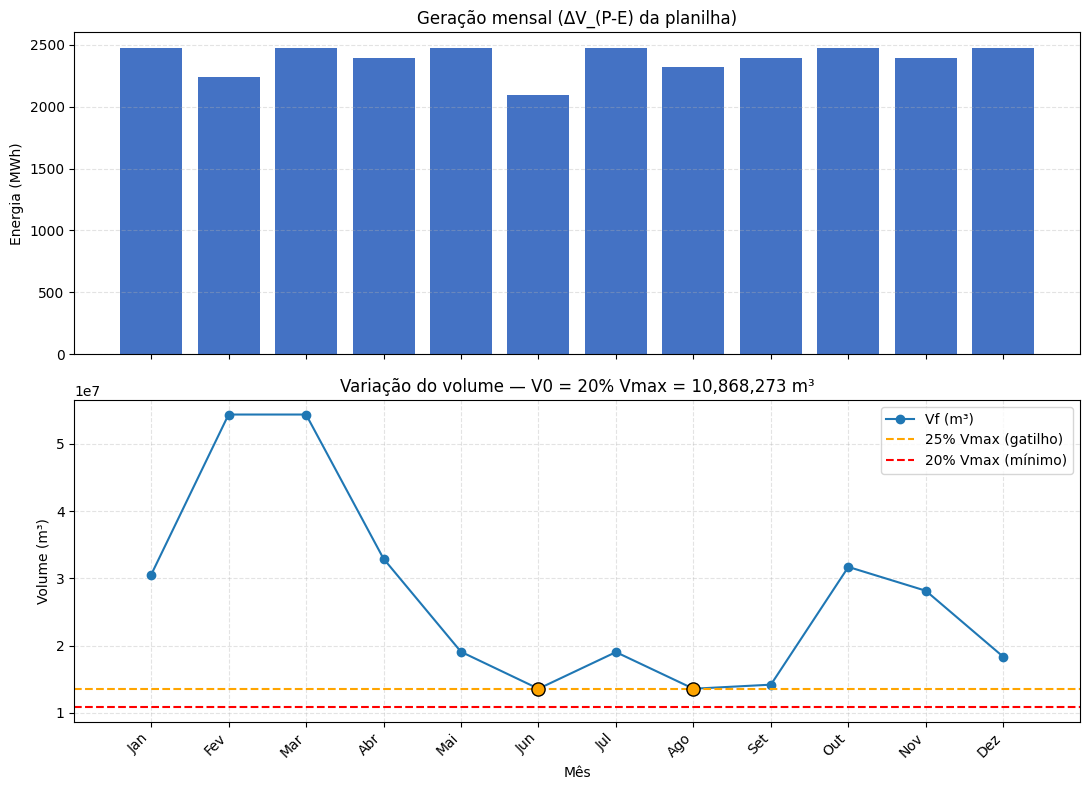

In [ ]:
import os, math, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- checagem de variáveis prévias ---------
for nm in ("a","c","Q_medio","altura_disp"):
    if nm not in globals():
        raise RuntimeError(f"Defina previamente '{nm}' nas células anteriores.")
a = float(a); c = float(c)
Q_medio = float(Q_medio)
Hdisp_const = float(altura_disp)

# --------- normalização de nomes e parsing numérico ---------
def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s)).encode("ascii","ignore").decode("ascii")
    return "".join(ch for ch in s if ch.isalnum()).lower()

def _find_col_any(df: pd.DataFrame, candidates):
    """Retorna a primeira coluna cujo nome normalizado contenha QUALQUER dos padrões."""
    cands = [c.lower() for c in candidates]
    for col in df.columns:
        nc = _norm(col)
        if any(pat in nc for pat in cands):
            return col
    return None

def _to_num(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        return pd.to_numeric(s, errors="coerce")
    return pd.to_numeric(s.astype(str).str.replace(",", ".", regex=False), errors="coerce")

# --------- escolher COM/SEM P&E ---------
use_PE = input("Usar planilha COM P/E (s) ou SEM P/E (n)? [s/n]: ").strip().lower() in ("s","sim","y")

# --------- localizar arquivo (prioriza PEE---2025 then current then /mnt/data) ---------
cand = [os.path.join("PEE---2025", "BalancoReservatorio_comPE_.xlsx" if use_PE else "BalancoReservatorio_semPE_.xlsx"),
        "BalancoReservatorio_comPE_.xlsx" if use_PE else "BalancoReservatorio_semPE_.xlsx", # current directory
        "/mnt/data/BalancoReservatorio_comPE_.xlsx" if use_PE else "/mnt/data/BalancoReservatorio_semPE_.xlsx",
        r"C:\Users\boffa\Downloads\TMP\BalancoReservatorio_comPE_.xlsx" if use_PE else r"C:\Users\boffa\Downloads\TMP\BalancoReservatorio_semPE_.xlsx"] # legacy path

ARQ = next((p for p in cand if os.path.exists(p)), None)

if not ARQ:
    # fallback: if the chosen one doesn't exist, try the other (semPE if comPE chosen, and vice-versa)
    use_PE_fallback = not use_PE
    cand_fallback = [os.path.join("PEE---2025", "BalancoReservatorio_comPE_.xlsx" if use_PE_fallback else "BalancoReservatorio_semPE_.xlsx"),
                     "BalancoReservatorio_comPE_.xlsx" if use_PE_fallback else "BalancoReservatorio_semPE_.xlsx",
                     "/mnt/data/BalancoReservatorio_comPE_.xlsx" if use_PE_fallback else "/mnt/data/BalancoReservatorio_semPE_.xlsx",
                     r"C:\Users\boffa\Downloads\TMP\BalancoReservatorio_comPE_.xlsx" if use_PE_fallback else r"C:\Users\boffa\Downloads\TMP\BalancoReservatorio_semPE_.xlsx"]
    ARQ = next((p for p in cand_fallback if os.path.exists(p)), None)
    if ARQ:
         print(f"Arquivo escolhido não encontrado. Usando arquivo alternativo: {ARQ}")
         use_PE = use_PE_fallback # Update use_PE flag

if not ARQ:
    raise FileNotFoundError("Não encontrei as planilhas com/sem P&E em nenhuma das localizações esperadas.")

print(f"Arquivo lido: {ARQ}")


# --------- leitura ---------
df = pd.read_excel(ARQ)

# nomes (robustos a acentos/símbolos):
col_mes   = _find_col_any(df, ["mes"])                        # "Mês"
col_dias  = _find_col_any(df, ["dias"])                       # "Dias"
col_qin   = _find_col_any(df, ["qin", "qinsint", "qsint"])    # "Q_in (m3/s)"
# delta V de P-E: padrões que cobrem "ΔV_(P-E) (m3)" após normalização → "vpem3" / "dvpem3"
col_dvpe  = _find_col_any(df, ["vpem3", "dvpem3", "deltavpem3", "deltavpe", "dvpe"])

if col_qin is None:
    raise KeyError(f"Coluna de vazão de entrada não encontrada. Colunas: {list(df.columns)}")

# construir vetores
meses = df[col_mes].astype(str).tolist() if col_mes else [f"Mês {i+1}" for i in range(len(df))]
if col_dias:
    dias = _to_num(df[col_dias]).fillna(0.0).to_numpy(float)
else:
    dias = np.array([31,28,31,30,31,30,31,31,30,31,30,31][:len(df)], dtype=float)

Qin = _to_num(df[col_qin]).fillna(0.0).to_numpy(float)  # m³/s
if col_dvpe:
    dV_PE = _to_num(df[col_dvpe]).fillna(0.0).to_numpy(float)  # m³
else:
    dV_PE = np.zeros(len(df), dtype=float)  # planilha sem P/E
print("\n[Diagnóstico]")
print(f"Mês .......: {col_mes}")
print(f"Dias ......: {col_dias}")
print(f"Q_in ......: {col_qin} | amostra: {df[col_qin].head(5).tolist()}")
print(f"ΔV_(P-E) ..: {col_dvpe} | amostra: {df[col_dvpe].head(5).tolist() if col_dvpe else '— (não encontrado, usando 0)'}")

# --------- geometria / funções ---------
Vmax = 750.0*(c**2)*a
rho, g = 1000.0, 9.81
eta_turb, eta_gen = 0.90, 0.95
eta_tot = eta_turb*eta_gen
seg_dia = 86400.0

def b_de_V(V):
    Vc = max(0.0, min(V, Vmax))
    A = 250.0*(c**2)/a; B = 500.0*(c**2); C = -Vc
    disc = B*B - 4*A*C
    if disc < 0: return 0.0
    r1 = (-B + math.sqrt(disc))/(2*A); r2 = (-B - math.sqrt(disc))/(2*A)
    return max(0.0, min(max(r1, r2, 0.0), a))
def A_lamina(b): return 500.0*(c**2)*(1.0 + b/a)

# avanço com ΔV_(P-E) fornecido
def advance_volume_dvpe(V_i, Qin_m3s, Qt_m3s, dV_PE_m3, dias):
    t_s = dias * seg_dia
    dV_Q = (max(Qin_m3s,0.0) - max(Qt_m3s,0.0)) * t_s
    V_f = V_i + dV_Q + float(dV_PE_m3)
    return max(0.0, min(V_f, Vmax))

# busca de Qturb (com piso) p/ atingir alvo usando dV_PE fixo
def find_qturb_with_floor(V_i, Qin_m3s, dV_PE_m3, dias, target_V, Qt_guess, Qt_min):
    lo, hi = max(0.0, Qt_min), max(0.0, Qt_guess)
    V_lo = advance_volume_dvpe(V_i, Qin_m3s, lo, dV_PE_m3, dias)  # maior V_f (menos turbinagem)
    V_hi = advance_volume_dvpe(V_i, Qin_m3s, hi, dV_PE_m3, dias)  # menor V_f
    if V_hi >= target_V - 1e-6: return hi, V_hi
    if V_lo <  target_V - 1e-6: return lo, V_lo
    for _ in range(40):
        mid = 0.5*(lo+hi)
        V_mid = advance_volume_dvpe(V_i, Qin_m3s, mid, dV_PE_m3, dias)
        if V_mid >= target_V: lo = mid
        else:                 hi = mid
    return lo, advance_volume_dvpe(V_i, Qin_m3s, lo, dV_PE_m3, dias)

# --------- simulação com piso e redução ---------
alpha_floor = 0.05
Qt_min = alpha_floor * Q_medio
Vmin, Vtrg = 0.20*Vmax, 0.25*Vmax

V_i = 0.20 * Vmax  # janeiro inicia com 20%

Vi, Vf, bi, bf, Ai, Af = [], [], [], [], [], []
Qturb_used, E_MWh = [], []
reduced_flag, viol_25_flag, viol_20_flag = [], [], []

for i in range(len(Qin)):
    t_s = float(dias[i]) * seg_dia
    # previsão com Qturb = Q_medio
    V_f_raw = advance_volume_dvpe(V_i, Qin[i], Q_medio, dV_PE[i], dias[i])

    if V_f_raw < Vtrg - 1e-6:
        Qt_use, V_f = find_qturb_with_floor(V_i, Qin[i], dV_PE[i], dias[i], Vtrg, Q_medio, Qt_min)
        reduced = Qt_use < Q_medio - 1e-9
    else:
        Qt_use, V_f = Q_medio, V_f_raw
        reduced = False

    viol25 = V_f < Vtrg - 1e-6
    viol20 = V_f < Vmin - 1e-6

    # energia (H = altura_disp; Qt = Qt_use)
    E_J = rho * g * Hdisp_const * eta_tot * Qt_use * t_s
    E_MWh.append(E_J / 3.6e9)

    b0 = b_de_V(V_i); b1 = b_de_V(V_f)
    Vi.append(V_i); Vf.append(V_f)
    bi.append(b0); bf.append(b1)
    Ai.append(A_lamina(b0)); Af.append(A_lamina(b1))
    Qturb_used.append(Qt_use)
    reduced_flag.append(reduced)
    viol_25_flag.append(viol25)
    viol_20_flag.append(viol20)

    V_i = V_f  # encadeia

# --------- saída e gráficos ---------
Vi, Vf = np.array(Vi), np.array(Vf)
bi, bf = np.array(bi), np.array(bf)
Qturb_used, E_MWh = np.array(Qturb_used), np.array(E_MWh)
reduced_flag = np.array(reduced_flag, bool)
viol_25_flag = np.array(viol_25_flag, bool)
viol_20_flag = np.array(viol_20_flag, bool)

out = pd.DataFrame({
    "Mês": meses,
    "Dias": dias.astype(int),
    "Q_in (m3/s)": np.round(Qin, 3),
    "Qturb alvo (m3/s)": np.round(Q_medio, 3),
    "Qturb piso (m3/s)": np.round(Qt_min, 3),
    "Qturb usado (m3/s)": np.round(Qturb_used, 3),
    "ΔV_(P-E) (m3)": np.round(dV_PE, 2),
    "Vi (m3)": np.round(Vi, 2),
    "Vf (m3)": np.round(Vf, 2),
    "b_i (m)": np.round(bi, 3),
    "b_f (m)": np.round(bf, 3),
    "%Vf/Vmax": np.round(100.0*Vf/Vmax, 2),
    "Redução?": reduced_flag,
    "<25% após piso?": viol_25_flag,
    "<20% após piso?": viol_20_flag,
    "Energia (MWh)": np.round(E_MWh, 2),
})
display(out)

# gráficos
fig, axes = plt.subplots(2, 1, figsize=(11, 8), sharex=True)

axes[0].bar(out["Mês"], out["Energia (MWh)"], color="#4472c4")
axes[0].set_ylabel("Energia (MWh)")
axes[0].set_title("Geração mensal (ΔV_(P-E) da planilha)")
axes[0].grid(axis="y", ls="--", alpha=0.35)

axes[1].plot(out["Mês"], out["Vf (m3)"], marker="o", label="Vf (m³)")
axes[1].axhline(0.25*Vmax, color="orange", ls="--", lw=1.5, label="25% Vmax (gatilho)")
axes[1].axhline(0.20*Vmax, color="red",    ls="--", lw=1.5, label="20% Vmax (mínimo)")
for i, m in enumerate(out["Mês"]):
    if reduced_flag[i]:
        axes[1].scatter(m, Vf[i], s=90, edgecolors="k", facecolors="#ffa500", zorder=5, label="_reduz")
    if viol_20_flag[i]:
        axes[1].scatter(m, Vf[i], s=110, edgecolors="k", facecolors="#ff3b30", zorder=6, label="_viol20")
axes[1].set_ylabel("Volume (m³)")
axes[1].set_xlabel("Mês")
axes[1].set_title(f"Variação do volume — V0 = 20% Vmax = {0.20*Vmax:,.0f} m³")
axes[1].legend(loc="best")
axes[1].grid(True, ls="--", alpha=0.35)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()